In [1015]:
# save files
fullproc_r = './resources/' # for words/names

# where to save the figures that are created
#fake_figs_dir = './example_hists/' # saving in github only for small numbers
# stop overwriting what is there
fake_figs_dir = '~/Downloads/tmp/JCDL2025/visual_qa_histograms/example_hists_complex/' # large dataset, same format
#fake_figs_dir = '~/LLM_VQA_JCDL2025/example_hists/fewshot/' # for fewshot learning


# format for saving images?
#img_format = ['pdf','jpeg']
img_format = ['jpeg']

# save diagnostic plot with all items labeled?
save_diagnostic_plot = True

# randomize names?
randomize_names = True

In [1016]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2 as cv
import pickle
import pandas as pd
#import string
from glob import glob
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import ImageColor
import json
import os
from copy import deepcopy
import copy

from utils.metric_utils.utilities import isRectangleOverlap

import time

import matplotlib as mpl
import os
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{amssymb}' #for \text command

# written libs -- will update locally
from utils.synthetic_fig_utils import subset_by_percent, \
 get_nrows_and_ncols, normalize_params_prob, get_ticks, get_titles_or_labels, \
 get_font_info

from utils.plot_utils import get_contour_plot, get_histogram_plot, \
   get_line_plot, get_scatter_plot, make_plot, colorbar_mods#, get_line_plot

from utils.text_utils import get_popular_nouns, get_inline_math

# create a bunch of fake figures
from utils.synthetic_fig_utils import normalize_params_prob
from utils.plot_parameters import plot_types_params, panel_params, \
  title_params, xlabel_params, colorbar_params, \
  ylabel_params, aspect_fig_params, dpi_params, tight_layout_params, \
  fontsizes, base

from utils.data_utils import get_data, NumpyEncoder
import numpy as np

import utils.distribution_utils

from importlib import reload
from utils.plot_qa_utils import log_scale_ax
import utils.distribution_utils
import utils.data_utils
reload(utils.distribution_utils)
reload(utils.data_utils)
from utils.data_utils import get_data
import utils.plot_classes_utils
reload(utils.plot_classes_utils)

from utils.synthetic_fig_utils import add_titles_and_labels

import utils.plot_utils
import utils.data_utils
import utils.plot_classes_utils
reload(utils.plot_classes_utils)
reload(utils.data_utils)
reload(utils.plot_utils)
from utils.plot_utils import make_plot, make_base_plot
from utils.data_utils import get_data

from utils.plot_utils import markers, make_base_plot

import utils.synthetic_fig_utils
reload(utils.synthetic_fig_utils)
from utils.synthetic_fig_utils import collect_plot_data_axes

marker_sizes = np.arange(0,10)+1
line_list_thick = np.arange(1,10)

use_uniques = True # use unique inlines
verbose = True

from sys import path
path.append('/Library/TeX/texbin/')

# debug
from importlib import reload

# for seed
from sys import maxsize as maxint

import warnings
warnings.filterwarnings("error")

In [1017]:
# for some versions
fake_figs_dir = os.path.expanduser(fake_figs_dir)
#fake_figs_dir

In [1018]:
# check directories
img_dir = fake_figs_dir + '/imgs/'
if not os.path.exists(img_dir):
    os.mkdir(img_dir)
    print('made:', img_dir)
json_dir = fake_figs_dir + '/jsons/'
if not os.path.exists(json_dir):
    os.mkdir(json_dir)
    print('made:', json_dir)

In [1019]:
# get fonts -- see "cnn_create_synthetic_ticks" in FullProcess
dfont = pd.read_csv(fullproc_r + 'fonts.csv')

# check that location is there
drop_names = []
for fl in dfont['font location']:
    if not os.path.exists(fl):
        drop_names.append(False)
    else:
        drop_names.append(True)

font_names = dfont.loc[drop_names]['font name'].values

# # for plot styles
# plot_styles = plt.style.available

# plot_types_qa = ['line', 'scatter', 'histogram']

plot_styles = ['default']

In [1020]:
# stats for doing calculations
stats = {'minimum':np.min, 'maximum':np.max, 'median':np.median, 'mean':np.mean}

# some things to try
aspect_cut = {'min':0.3, 'max':4.0}

In [1021]:
# XYZ -- IS THIS USED NOW??
# get popular words for titles/axis
popular_nouns = get_popular_nouns(fullproc_r + 'data/')

# get inline math formulas
inlines = get_inline_math(fullproc_r,
                          recreate_inlines=False,
                         use_uniques=use_uniques)

16254 343520
shape of output= (5098, 5)
shape of output= (36335, 5)
number of inlines =  33201


## Update plotting params

### Plot type params

In [1022]:
plot_params = plot_types_params.copy()

In [1023]:
# prob for getting a histogram
plot_params['histogram']['prob'] = 1

# XYZ: since auto-setting plot_type later, can probably get away with none of the stuff in this cell
# probability of getting a scatter plot
plot_params['scatter']['prob'] = 0
# probability of getting a line
plot_params['line']['prob'] = 0
# prob of getting a contour plot
plot_params['contour']['prob'] = 0

In [1024]:
linestyles_hist = ['-'] #, '--', ':'] # only use a subset of the linestyles

plot_params['histogram'] = plot_params['histogram'].copy()

# no horizontal plots
plot_params['histogram']['horizontal prob'] = 0.25

# random distributions
plot_params['histogram']['distribution']['random']['prob'] = 1

# gaussian mixture model
plot_params['histogram']['distribution']['gmm']['prob'] = 1
plot_params['histogram']['distribution']['gmm']['nclusters'] = {'min': 1, 'max': 5}
plot_params['histogram']['distribution']['gmm']['nsamples'] = {'min': 10, 'max': 50}

# linear distributions prob
plot_params['histogram']['distribution']['linear']['prob'] = 1

plot_params['histogram']['nbins'] = {'min':5, 'max':50} # number of bars
plot_params['histogram']['error bars']['elinewidth'] = {'min':1, 'max':3}

In [1025]:
#plot_types_params['histogram']['nbins']

In [1026]:
# choices = []; probs = []
# for k,v in plot_params_out.items():
#     choices.append(k)
#     probs.append(v['prob'])

# plot_type = rng.choice(choices, p=probs)
# plot_type
plot_type = 'histogram' # fix this

### Other parameters

In [1027]:
# for ease of things, lets not do equations here
title_params['equation']['prob'] = 0.25 # probability any word will be equation
xlabel_params['equation']['prob'] = 0.25 # probability any word will be equation
ylabel_params['equation']['prob'] = 0.25 # probability any word will be equation

Renormalize all probabilities:

In [1028]:
# reload for debug
import utils.synthetic_fig_utils
reload(utils)
reload(utils.synthetic_fig_utils)
from utils.synthetic_fig_utils import normalize_params_prob

plot_params_out, panel_params, \
  title_params, xlabel_params, \
  ylabel_params = normalize_params_prob(plot_params.copy(), panel_params, 
                                        title_params, xlabel_params, 
                                        ylabel_params, colorbar_params)

plot_params_out

plot_types_params['histogram']['distribution'] probabilities did not add to 1! total = 3
renormalizing...
now:  [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]


{'line': {'prob': 0,
  'npoints': {'min': 10, 'max': 11},
  'line thick': {'min': 1, 'max': 5},
  'nlines': {'min': 2, 'max': 3},
  'xmin': -10000,
  'xmax': 10000,
  'ymin': -10000,
  'ymax': 10000,
  'prob same x': 0.1,
  'markers': {'prob': 0.5, 'size': {'min': 1, 'max': 20}},
  'error bars': {'elinewidth': {'min': 1, 'max': 5},
   'x': {'prob': 0.25, 'size': {'min': 0.01, 'max': 0.1}},
   'y': {'prob': 0.25, 'size': {'min': 0.01, 'max': 0.1}}},
  'distribution': {'random': {'prob': 0.3333333333333333},
   'linear': {'prob': 0.3333333333333333,
    'intersect': (-100, 100),
    'slope': (-5, 5),
    'noise': (0, 0.25)},
   'gmm': {'prob': 0.3333333333333333,
    'histogram as line': {'prob': 0.25, 'factor': 1000},
    'nclusters': {'min': 1, 'max': 20},
    'nsamples': {'min': 10, 'max': 500},
    'cluster std': {'min': -2, 'max': 0.5},
    'noise': {'min': 0.05, 'max': 0.25}}}},
 'histogram': {'prob': 1,
  'npoints': {'min': 10, 'max': 10000},
  'nbins': {'min': 5, 'max': 50},
  'r

### Run the thing

In [1029]:
# Set a seed if you want a reproducible thing
seed_outer = np.random.randint(maxint)
#seed_outer = 7526304181034464103
#seed_outer = 6700012876856450103

print('seed_outer =',seed_outer)
rng_outer = np.random.default_rng(seed_outer)

seed_outer = 248348924888858093


In [1030]:
# "Inner" seed -- for things like distributions and whatnot
seed = np.random.randint(maxint)
#seed = 2870146871786070273
#seed = 7067533564274193147
print('seed = ', seed)
# based on seed, make random number generator, see: https://numpy.org/doc/2.2/reference/random/generator.html
rng = np.random.default_rng(seed)

# for titles
seed_titles = np.random.randint(maxint)
rng_titles = np.random.default_rng(seed_titles)

# for fonts
seed_font = np.random.randint(maxint)
rng_font = np.random.default_rng(seed_font)

# aspect ratio
seed_aspect = np.random.randint(maxint)
rng_aspect = np.random.default_rng(seed_aspect)

# used?
#condition_overlap_xticklabels = True

seed =  9026895327509677764


In [1031]:
panel_params.keys()

dict_keys(['number prob', 'layout prob', 'to even above'])

## Example auto-generated figure

In [1032]:
aspect_fig_params['min'], aspect_fig_params['max']

(0.5, 2.0)

In [1033]:
# set some things to keep standard across images

tight_layout = True

color_map = rng_outer.choice(plt.colormaps()) # choose a color map

plot_style = rng_outer.choice(plot_styles) # choose a plotting style

npanels, panel_style, nrows, ncols = 1, 'square', 1, 1 # keep single image

aspect_fig = rng_outer.uniform(low=aspect_fig_params['min'], high=aspect_fig_params['max'])

dpi = int(rng_outer.uniform(low=dpi_params['min'], high=dpi_params['max']))

print('Color map:', color_map)
print('Plot style:', plot_style)
print('Aspect ratio:', aspect_fig)
print('DPI:', dpi)

Color map: gist_rainbow_r
Plot style: default
Aspect ratio: 0.9769016228700349
DPI: 144


In [1034]:
# use the "fixed" RNG outer
# get all font stuffs
title_fontsize, colorbar_fontsize, xlabel_fontsize, ylabel_fontsize, \
    xlabel_ticks_fontsize, ylabel_ticks_fontsize, \
                        csfont = get_font_info(fontsizes, font_names, rng=rng_titles)
print('Font info:', csfont)

Font info: {'fontname': 'Tamil MN'}


Get distribution based on randomized selection:

In [1035]:
# get distribution type
dist_params = plot_params_out[plot_type]['distribution'] 
choices_d = []; probs_d = []
for k,v in dist_params.items():
    choices_d.append(k)
    probs_d.append(v['prob'])

distribution_type = np.random.choice(choices_d, p=probs_d)
print('Distribution Type:', distribution_type)

Distribution Type: linear


In [1036]:
xmin,xmax = log_scale_ax()
plot_params_out[plot_type]['xmin']=xmin
plot_params_out[plot_type]['xmax']=xmax
print('xmin, xmax = ', xmin, xmax)

xmin, xmax =  -8.794377515714574 5.8124873220891615


In [1037]:
success_get_data = False
while not success_get_data:
    data_for_plot = get_data(plot_params_out[plot_type], 
                             plot_type=plot_type, distribution=distribution_type, rng=rng)
    if len(data_for_plot['xs']) > 0 and plot_type == 'histogram':
        success_get_data = True

In [1038]:
def get_new_title(title_fontsize, rng, fontsize_min=8):

    title_fontsize -= 1
    err = False

    if title_fontsize < fontsize_min:
        err = True
        print("[ERROR]: can't make font size smaller, gonna grab new words for title and try again...")
        #xlabels_pull = xlabel # keep same
        #ylabels_pull = ylabel
        title_fontsize, _, _, _, _, _, _ = get_font_info(fontsizes, font_names, rng=rng)
        # title, _, _ = add_titles_and_labels(ax, xlabel, ylabel, titles_pull, 
        #                                     title_params, csfont, title_fontsize, 
        #                 xlabel_params, ylabel_params, xlabel_fontsize, ylabel_fontsize,
        #                 inlines, xlabel_ticks_fontsize, ylabel_ticks_fontsize,
        #                 rng=rng)
    return title_fontsize, err


def get_new_xylabels(xlabel_fontsize, ylabel_fontsize, rng, fontsize_min = 8):
    xlabel_fontsize -= 1
    ylabel_fontsize -= 1    
    err = False

    if xlabel_fontsize < fontsize_min or ylabel_fontsize < fontsize_min:
        err = True
        print("[ERROR]: can't make font size smaller, gonna grab new words for x/y axis labels and try again...")
        _, _, xlabel_fontsize, ylabel_fontsize, _, _, _ = get_font_info(fontsizes, font_names, rng=rng)
        # _, xlabel, ylabel = add_titles_and_labels(ax, xlabels_pull, ylabels_pull, title, 
        #                                     title_params, csfont, title_fontsize, 
        #                 xlabel_params, ylabel_params, xlabel_fontsize, ylabel_fontsize,
        #                 inlines, xlabel_ticks_fontsize, ylabel_ticks_fontsize,
        #                 rng=rng)
    return xlabel_fontsize, ylabel_fontsize, err

In [1039]:
def reset_all_params(plot_params_input, popular_nouns, plot_styles, fontsizes, font_names, dpi_params,
                     colormaps = plt.colormaps()):
    """
    If there is major failure, reset all randomized params and try to remake the plot.
    """
    plot_params_in = deepcopy(plot_params_input)
    success_titles = False
    seed_aspect = np.random.randint(maxint)
    rng_aspect = np.random.default_rng(seed_aspect)
    seed_titles = np.random.randint(maxint)
    rng_titles = np.random.default_rng(seed_titles)
    aspect_fig = rng_aspect.uniform(low=aspect_fig_params['min'], high=aspect_fig_params['max'])
    xlabels_pull = deepcopy(popular_nouns)
    ylabels_pull = deepcopy(popular_nouns)
    titles_pull = deepcopy(popular_nouns)
    seed_outer= np.random.randint(maxint)
    rng_outer = np.random.default_rng(seed_outer)
    color_map = rng_outer.choice(colormaps) # choose a color map
    plot_style = rng_outer.choice(plot_styles) # choose a plotting style
    # dist params
    dist_params = plot_params_in[plot_type]['distribution'] 
    choices_d = []; probs_d = []
    for k,v in dist_params.items():
        choices_d.append(k)
        probs_d.append(v['prob'])
    distribution_type = rng_outer.choice(choices_d, p=probs_d)
    # get fonts
    title_fontsize, colorbar_fontsize, xlabel_fontsize, ylabel_fontsize, \
        xlabel_ticks_fontsize, ylabel_ticks_fontsize, \
                            csfont = get_font_info(fontsizes, font_names, rng=rng_titles)
    # get DPI
    dpi = int(rng_outer.uniform(low=dpi_params['min'], high=dpi_params['max']))
    # get data
    # pull xmin/xmax for hists
    xmin,xmax = log_scale_ax()
    plot_params_in[plot_type]['xmin']=xmin
    plot_params_in[plot_type]['xmax']=xmax
    if verbose: print('xmin, xmax = ', xmin, xmax)

    # get plot data
    success_get_data = False
    while not success_get_data:
        data_for_plot = get_data(plot_params_in[plot_type], 
                                plot_type=plot_type, distribution=distribution_type, rng=rng)
        if len(data_for_plot['xs']) > 0 and plot_type == 'histogram':
            success_get_data = True


    return success_titles, rng_aspect, rng_titles, aspect_fig, xlabels_pull, ylabels_pull, \
        titles_pull, rng_outer, color_map, plot_style, dist_params, distribution_type, \
    title_fontsize, colorbar_fontsize, xlabel_fontsize, ylabel_fontsize, \
        xlabel_ticks_fontsize, ylabel_ticks_fontsize, \
                            csfont, dpi, xmin,xmax, plot_params_in, data_for_plot        

In [1040]:
from utils.figure_gen_utils.misc import add_annotations

In [1041]:
# shorten checks
def check_aspect(datas, success_titles, aspect_fig):
    """
    Check if the resulting aspect ratio of the figure is super small.  If so, flag to re-run stuff.
    """
    # 1. Check for square with weird aspect ratio
    success_aspect = True
    # check for thin/fat squares
    for k,v in datas.items():
        if 'plot' in k: # a plot key
            w = v['square']['xmax']-v['square']['xmin']
            h = v['square']['ymax']-v['square']['ymin']
            if w/h > aspect_cut['max'] or w/h < aspect_cut['min']:
                success_aspect = False

    if not success_aspect:
        print('[ERROR]: aspect ratio off')
        # regenerate figure with new aspect ratio
        success_titles = False
        seed_aspect = np.random.randint(maxint)
        rng_aspect = np.random.default_rng(seed_aspect)
        aspect_fig = rng_aspect.uniform(low=aspect_fig_params['min'], high=aspect_fig_params['max'])

    return success_titles, success_aspect, aspect_fig


def check_labels_titles_off_page(datas, width, height, success_titles, 
                                 xlabels_pull, ylabels_pull, titles_pull,
                                 xlabel_fontsize, ylabel_fontsize, rng_titles, 
                                 popular_nouns, title_fontsize, 
                                 fontsize_min = 8, verbose=True):
    """
    Check if any of the x-axis labels, y-axis labels, or titles is off the page of the figure.  
    If so, try to make the fontsize smaller and re-run.  If the fontsize is smaller than 
    the `fontsize_min` parameter, flag to re-pull new x/y axis labels and titles.
    """
    # check for overlaps of x/y axis labels, tickmarks or anything outside of the figbox
    success_axis_labels = True
    success_title_label = True
    for k,v in datas.items():
        if 'plot' in k: # a plot key
            # check if x is out of bounds
            for axislabel in ['xlabel', 'ylabel']:
                if v[axislabel]['xmin'] < 0 or v[axislabel]['xmax'] > width or \
                    v[axislabel]['ymin'] < 0 or v[axislabel]['ymax'] > height:
                    success_axis_labels = False
            # also title
            if 'title' in v:
                if v['title']['xmin'] < 0 or v['title']['xmax'] > width or \
                    v['title']['ymin'] < 0 or v['title']['ymax'] > height:
                    success_title_label = False

        if not success_axis_labels:
            if verbose: 
                print('[ERROR]: x/y axis off page, making smaller...')
                print('   x/y axis labels:', xlabels_pull, ylabels_pull)
            xlabel_fontsize, ylabel_fontsize, err = get_new_xylabels(xlabel_fontsize, ylabel_fontsize, rng_titles, 
                                                                                fontsize_min = fontsize_min)
            # regenerate x/y titles if fontsize too small
            success_titles = False
            if err: # regenerate labels
                xlabels_pull = deepcopy(popular_nouns)
                ylabels_pull = deepcopy(popular_nouns)
                # reset RNG for labels
                seed_titles = np.random.randint(maxint)
                rng_titles = np.random.default_rng(seed_titles)
            else:
                if verbose: print('   new fontsizes (x,y):', xlabel_fontsize, ylabel_fontsize)

        if not success_axis_labels and err:
            return success_titles, xlabel_fontsize, ylabel_fontsize, title_fontsize, xlabels_pull, ylabels_pull, titles_pull, rng_titles, success_title_label, success_axis_labels

        if not success_title_label:
            if verbose:
                print('[ERROR]: title axis off page, making smaller...')
            title_fontsize, err = get_new_title(title_fontsize, rng_titles, 
                                                fontsize_min=fontsize_min)
            # regenerate titles if fontsize too small
            success_titles = False
            if err:
                titles_pull = deepcopy(popular_nouns)
                # reset RNG for labels
                seed_titles = np.random.randint(maxint)
                rng_titles = np.random.default_rng(seed_titles)
            else:
                if verbose: print('   new fontsize:', title_fontsize)

            #break # I think...         
    return success_titles, xlabel_fontsize, ylabel_fontsize, title_fontsize, xlabels_pull, ylabels_pull, titles_pull, rng_titles, success_title_label, success_axis_labels



In [1042]:
def collect_boxes(datas, grace_ticks=5):
    """
    Collect all potential bounding boxes in a figure (can be for multi-panel figures too).
    """
    # now check overlapping boxes
    # first make boxes
    boxes_check = []
    success_boxes = True
    for k,v in datas.items():
        if 'plot' in k: # a plot key
            # square!
            boxes_check.append(([v['square']['xmin'], v['square']['ymin'], 
                                        v['square']['xmax'], v['square']['ymax']], 'square'))
            if 'title' in v:
                boxes_check.append( ([v['title']['xmin'], v['title']['ymin'], 
                                        v['title']['xmax'], v['title']['ymax']], 'title') )
            # xlabel
            boxes_check.append( ([v['xlabel']['xmin'], v['xlabel']['ymin'], 
                                        v['xlabel']['xmax'], v['xlabel']['ymax']], 'xlabel') )
            # ylabel
            boxes_check.append( ([v['ylabel']['xmin'], v['ylabel']['ymin'], 
                                        v['ylabel']['xmax'], v['ylabel']['ymax']],'ylabel')  )
            # x/yticks
            for t in ['x','y']:
                for tick in v[t+'ticks']:
                    # ignore things that are outside square
                    if tick['tx'] < v['square']['xmin']-grace_ticks or tick['tx'] > v['square']['xmax']+grace_ticks or \
                      tick['ty'] < v['square']['ymin']-grace_ticks or tick['ty'] > v['square']['ymax']+grace_ticks:
                        continue
                    boxes_check.append( ([tick['xmin'],tick['ymin'],tick['xmax'],tick['ymax']],t+'-tick labels') )
            # x/y offset labels
            for t in ['x','y']:
                if t + '-offset text' in v:
                    tick = v[t + '-offset text']
                    boxes_check.append( ([tick['xmin'],tick['ymin'],tick['xmax'],tick['ymax']],t+'-offset text') )

            # if colorbar, add this
            if 'color bar' in v:
                boxes_check.append(([v['color bar']['xmin'], v['color bar']['ymin'], 
                                        v['color bar']['xmax'], v['color bar']['ymax']],'colorbar'))
                # also check for label
                if 'label' in v['color bar']:
                    xmin = v['color bar']['label']['xmin']
                    ymin = v['color bar']['label']['ymin']
                    xmax = v['color bar']['label']['xmax']
                    ymax = v['color bar']['label']['ymax']
                    boxes_check.append(([xmin,ymin,xmax,ymax],'colorbar label'))
                # and offset text
                if 'offset text' in v['color bar']:
                    xmin = v['color bar']['offset text']['xmin']
                    ymin = v['color bar']['offset text']['ymin']
                    xmax = v['color bar']['offset text']['xmax']
                    ymax = v['color bar']['offset text']['ymax']
                    boxes_check.append(([xmin,ymin,xmax,ymax],'colorbar offset text'))
                    
            # colorbar ticks
            if 'color bar ticks' in v:
                for tick in v['color bar ticks']:
                    boxes_check.append( ([tick['xmin'],tick['ymin'],tick['xmax'],tick['ymax']], 'colorbar tick') )

    # now run and check all boxes -- look for overlap of all boxes
    names_overlap = []
    for ib1,(box1,name1) in enumerate(boxes_check):
        for ib2,(box2,name2) in enumerate(boxes_check):
            if ib1 != ib2: # ib1 < ib2?
                if isRectangleOverlap( box1, box2 ):
                    names_overlap.append( (name1, name2) )
                    success_boxes = False

    return success_boxes, boxes_check, names_overlap


def update_fonts_boxes_overlap(names_overlap, success_titles, rng_titles,popular_nouns,
                            xlabels_pull, ylabels_pull, titles_pull,
                            xlabel_ticks_fontsize, ylabel_ticks_fontsize, 
                            xlabel_fontsize, ylabel_fontsize, title_fontsize,
                               verbose=True, fontsize_min=8):
    """
    Check if there are any overlapping bounding boxes.  If so, try to update fonts 
    if possible, and if not, flag to regenerate the figure.
    """
    if verbose: print('[ERROR]: overlapping boxes!')
    # figure out what to do for each box
    # get unique overlaps
    s1 = np.unique(names_overlap, axis=0)
    # sort
    s2 = np.unique(np.sort(s1, axis=1),axis=0)

    ######## check boxes ##########
    reset_fonts = False
    for b1,b2 in s2:
        # for ticks overlapping with things
        if 'tick' in b1 and 'tick' in b2: # overlapping ticks, smallen
            xlabel_ticks_fontsize -= 1
            ylabel_ticks_fontsize -= 1
            success_titles = False
            break
        elif ( ('tick' in b1) and ('tick' not in b2) and  ('xlabel' in b2) ) or ( ('tick' in b2) and ('tick' not in b1) and  ('xlabel' in b1) ): # xlabel cross over
            if xlabel_fontsize > xlabel_ticks_fontsize: # axis label still bigger
                xlabel_ticks_fontsize -= 1
                ylabel_ticks_fontsize -= 1
            else:
                xlabel_fontsize -= 1
            success_titles = False
            break            
        elif ( ('tick' in b1) and ('tick' not in b2) and  ('ylabel' in b2) ) or ( ('tick' in b2) and ('tick' not in b1) and  ('ylabel' in b1) ): # ylabel cross over
            if ylabel_fontsize > ylabel_ticks_fontsize: # axis label still bigger
                xlabel_ticks_fontsize -= 1
                ylabel_ticks_fontsize -= 1
            else:
                ylabel_fontsize -= 1
            success_titles = False
            break   
        elif ( ('tick' in b1) and ('tick' not in b2) and  ('title' in b2) ) or ( ('tick' in b2) and ('tick' not in b1) and  ('title' in b1) ): # title cross over
            if title_fontsize > ylabel_ticks_fontsize or title_fontsize > xlabel_ticks_fontsize: # axis label still bigger
                xlabel_ticks_fontsize -= 1
                ylabel_ticks_fontsize -= 1
            else:
                title_fontsize -= 1
            success_titles = False
            break   
        elif ( ('xlabel' in b1) or ('xlabel' in b2) or ('ylabel' in b1) or ('ylabel' in b2) ): # overlap
            ylabel_fontsize -= 1
            xlabel_fontsize -= 1
            success_titles = False
            break
        elif ('title' in b1) or ('title' in b2):
            title_fontsize -= 1
            success_titles = False
            break
        else: # no idea!
            reset_fonts = True

    # full rest of fonts
    for fs in [xlabel_fontsize, ylabel_fontsize, ylabel_ticks_fontsize, xlabel_ticks_fontsize, title_fontsize]:
        if fs < fontsize_min:
            reset_fonts = True    

    if reset_fonts:
        xlabels_pull = deepcopy(popular_nouns)
        ylabels_pull = deepcopy(popular_nouns)
        titles_pull = deepcopy(popular_nouns)
        # reset RNG for labels
        seed_titles = np.random.randint(maxint)
        rng_titles = np.random.default_rng(seed_titles)\
        
    return success_titles, xlabel_fontsize, ylabel_fontsize, ylabel_ticks_fontsize, xlabel_ticks_fontsize, title_fontsize, xlabels_pull, ylabels_pull, titles_pull, rng_titles

In [1043]:
plot_one = False # plot one or not?


fontsize_min = 8 # minimum to try to shrink titles
aspect_cut = {'min':0.3, 'max':4.0}


success_plot = False # overall plot

# flags for various things
success_titles = False

# keep titles
xlabels_pull = deepcopy(popular_nouns)
ylabels_pull = deepcopy(popular_nouns)
titles_pull = deepcopy(popular_nouns)

grace_ticks = 5 # ignore tick marks that are outside the box by this -- invisible most likely
itriesMax = 100 # start again if too many tries

ifigure = 0
itries = 0
while not success_plot and itries <= itriesMax and plot_one:
    itries += 1
    if itries >= itriesMax: # update everybody
        success_titles, rng_aspect, rng_titles, aspect_fig, xlabels_pull, ylabels_pull, \
                titles_pull, rng_outer, color_map, plot_style, dist_params, distribution_type, \
            title_fontsize, colorbar_fontsize, xlabel_fontsize, ylabel_fontsize, \
                xlabel_ticks_fontsize, ylabel_ticks_fontsize, \
                                    csfont, dpi, xmin,xmax, \
                                        plot_params_in, data_for_plot = reset_all_params(plot_params_out, 
                                                                                         popular_nouns, 
                                                                                         plot_styles, 
                                                                                         fontsizes, 
                                                                                         font_names, 
                                                                                         dpi_params)
        success_plot = False

    rng = np.random.default_rng(seed)
    while not success_titles: # ensure we catch any errors with bad fonts
        try:
            # make figure object
            fig, axes, plot_inds = make_base_plot(plot_style, color_map, dpi, nrows, ncols, aspect_fig,
                            base=2, verbose=True, tight_layout = tight_layout)
            # make plot based on data we already got
            data_from_plot, ax = make_plot(plot_params_out[plot_type], data_for_plot, 
                                    axes[0], plot_type=plot_type, linestyles=linestyles_hist, 
                                    rng=rng)
            # generate x/y labels and titles
            title, xlabel, ylabel = add_titles_and_labels(axes[0], xlabels_pull, ylabels_pull, titles_pull, 
                                                    title_params, csfont, title_fontsize, 
                                xlabel_params, ylabel_params, xlabel_fontsize, ylabel_fontsize,
                                inlines, xlabel_ticks_fontsize, ylabel_ticks_fontsize,
                                rng=rng_titles)
            # set "pulls" to save, reset letter as needed
            try:
                xlabels_pull = xlabel.get_text()
            except:
                if type(xlabel) == type([]) or type(xlabel) == type('hi'):
                    xlabels_pull = xlabel
                else:
                    lfkasjl
            try:
                ylabels_pull = ylabel.get_text()
            except:
                if type(ylabel) == type([]) or type(ylabel) == type('hi'):
                    ylabels_pull = ylabel
                else:
                    flasj
            try:
                titles_pull = title.get_text()
            except:
                if type(title) == type([]) or type(title) == type('hi'):
                    titles_pull = title
                else:
                    flasj
            # flag as success after render      
            success_titles = True
            plt.draw()
            plt.pause(0.001)
        except Exception as e:
            plt.close('all')
            #print("HERE")
            if 'missing from font' in str(e):
                print('[ERROR]: missing font (' + str(e) + '), will try with new font')
                seed_font = np.random.randint(maxint)
                rng_font = np.random.default_rng(seed_font)
                try:
                    _, _, _, _, _, _, csfont = get_font_info(fontsizes, font_names, rng=rng_font)
                except Exception as e2:
                    pass
                success_titles = False
            else:
                print('[ERROR]: other error - ', str(e))
                laslfjasl
            continue

    ###### SAVE FIG and collect bounding boxes #####
    plt.set_cmap(color_map) # do again
    fig.tight_layout()
    # collect data
    fig.canvas.draw()
    width, height = fig.canvas.get_width_height()
    # save data
    datas = {}
    # figure datas
    datas['figure'] = {'dpi':dpi, 'base':base, 'aspect ratio': aspect_fig, 
                        'nrows':nrows, 'ncols':ncols, 
                        'plot style':plot_style, 
                        'color map':color_map,
                        'title fontsize':title_fontsize, 
                        'xlabel fontsize':xlabel_fontsize,
                        'ylabel fontsize':ylabel_fontsize, 
                    'plot indexes':plot_inds}
    for iplot,ax in enumerate(axes): ### XYZ, only 1 axis here
        datas['plot' + str(iplot)] = collect_plot_data_axes(ax, fig,
                        height, width,
                        data_from_plot, data_for_plot, 
                        plot_type, title, 
                        xlabel, ylabel,
                        distribution_type, verbose=True)
        

    ########### CHECKS -- titles off, bounding boxes, etc ##########
    # 1. Check for square with weird aspect ratio
    success_titles, success_aspect, aspect_fig = check_aspect(datas, success_titles, aspect_fig)
    if not success_aspect:
        continue

    # 2. Check if titles or x/y axis labels are running off the page         
    success_titles, xlabel_fontsize, ylabel_fontsize, title_fontsize, \
        xlabels_pull, ylabels_pull, titles_pull, rng_titles, \
            success_title_label, success_axis_labels = check_labels_titles_off_page(datas, width, height, success_titles, 
                                 xlabels_pull, ylabels_pull, titles_pull, 
                                 xlabel_fontsize, ylabel_fontsize, rng_titles, 
                                 popular_nouns, title_fontsize, 
                                 fontsize_min = fontsize_min, verbose=verbose)

    if not success_title_label or not success_axis_labels:
        continue
            

    # 3. Save the fig, check if we have issues opening it
    # for diagnostics! -- move to after success of fig!
    for iformat in img_format:
        fig.savefig(fake_figs_dir + 'imgs/Picture' + str(ifigure+1).zfill(6) + '.'+iformat, dpi=dpi)#, bbox_inches='tight')
        print('saved:', fake_figs_dir + 'imgs/Picture' + str(ifigure+1).zfill(6) + '.' +iformat)
    # check if issue opening plot
    e = ''
    try:
        for iformat in img_format:
            img = np.array(Image.open(fake_figs_dir + 'imgs/Picture' + str(ifigure+1).zfill(6) + '.' + iformat))
    except Exception as e:
        success_titles = False
        # redo_gen_fig = True
        # redo_gen_plot = True
        if verbose: 
            print('[ERROR]: Issue with opening image!')
            if str(e) != '': print('Full error:', str(e))
    if not success_titles:
        continue


    # 4. Check if any bounding boxes are overlapping
    success_boxes, boxes_check, names_overlap = collect_boxes(datas, grace_ticks=grace_ticks)

    if save_diagnostic_plot:
        img_diag = np.array(Image.open(fake_figs_dir + 'imgs/Picture' + str(ifigure+1).zfill(6) + '.' + img_format[0]).convert('RGB'))
        imgplot = add_annotations(img_diag, img_diag, deepcopy(datas))            

    if not success_boxes: # check who overlaps with who
        success_titles, xlabel_fontsize, ylabel_fontsize, ylabel_ticks_fontsize, \
            xlabel_ticks_fontsize, title_fontsize, xlabels_pull, \
                ylabels_pull, titles_pull, rng_titles = update_fonts_boxes_overlap(names_overlap, success_titles, rng_titles,popular_nouns,
                                xlabels_pull, ylabels_pull, titles_pull,
                            xlabel_ticks_fontsize, ylabel_ticks_fontsize, 
                            xlabel_fontsize, ylabel_fontsize, title_fontsize,
                               verbose=verbose, fontsize_min=fontsize_min)
        continue


    success_plot = True # hurray if we've made it this far!
    # if all went well, reset seed
    seed = np.random.randint(maxint)

    print('SUCCESS')
    plt.close(fig)
    # dump full data
    dumped = json.dumps(datas, cls=NumpyEncoder)
    with open(fake_figs_dir + 'jsons/Picture' + str(ifigure+1).zfill(6) + '.json', 'w') as f:
        json.dump(dumped, f)


if success_plot:
    print('DONE MAKING PLOT!')
else:
    print("--- maxed out tries, plot failed ---")

--- maxed out tries, plot failed ---


## Make a series of histogram plots

These will all still be single-panel.

In [1044]:
# based on seed, make random number generator, see: https://numpy.org/doc/2.2/reference/random/generator.html
def set_all_seeds(rng_outer=np.random, rng=np.random, rng_titles=np.random, rng_font=np.random, rng_aspect=np.random,
                  reset_outer = False, reset_inner = False, reset_titles=False, reset_fonts = False, reset_aspect = False,
                  verbose=True):
    if reset_outer:
        seed_outer = np.random.randint(maxint)
        if verbose: print('seed_outer =',seed_outer)
        rng_outer = np.random.default_rng(seed_outer)

    # "Inner" seed -- for things like distributions and whatnot
    if reset_inner:
        seed = np.random.randint(maxint)
        if verbose: print('seed, inner = ', seed)
        rng = np.random.default_rng(seed)

    # for titles
    if reset_titles:
        seed_titles = np.random.randint(maxint)
        if verbose: print('seed_titles:', seed_titles)
        rng_titles = np.random.default_rng(seed_titles)

    # for fonts
    if reset_fonts:
        seed_font = np.random.randint(maxint)
        if verbose: print('seed_font:', seed_font)
        rng_font = np.random.default_rng(seed_font)

    # aspect ratio
    if reset_aspect:
        seed_aspect = np.random.randint(maxint)
        if verbose: print('seed_aspect:', seed_aspect)
        rng_aspect = np.random.default_rng(seed_aspect)

    return rng_outer, rng, rng_titles, rng_font, rng_aspect

In [1045]:
import utils.plot_qa_utils
reload(utils.plot_qa_utils)
from utils.plot_qa_utils import init_qa_pairs

import utils.histogram_plot_qa_utils
reload(utils.histogram_plot_qa_utils)
from utils.histogram_plot_qa_utils import q_nbars_hist_plot_plotnums, q_stats_hists, q_gmm_ngaussians_hists

import utils.synthetic_fig_utils
reload(utils.synthetic_fig_utils)
from utils.synthetic_fig_utils import collect_plot_data_axes


*************** Figure 0 ****************
  already have: /Users/jnaiman/Downloads/tmp/JCDL2025/visual_qa_histograms/example_hists_complex/imgs/Picture000001.<FMT>

*************** Figure 1 ****************
  already have: /Users/jnaiman/Downloads/tmp/JCDL2025/visual_qa_histograms/example_hists_complex/imgs/Picture000002.<FMT>

*************** Figure 2 ****************
  already have: /Users/jnaiman/Downloads/tmp/JCDL2025/visual_qa_histograms/example_hists_complex/imgs/Picture000003.<FMT>

*************** Figure 3 ****************
  already have: /Users/jnaiman/Downloads/tmp/JCDL2025/visual_qa_histograms/example_hists_complex/imgs/Picture000004.<FMT>

*************** Figure 4 ****************
seed_outer = 6223092997405304231
seed, inner =  7367855354546543683
seed_titles: 8681407799477025386
seed_font: 9072365677446066374
seed_aspect: 7801163239886525132
Distribution Type: random
xmin, xmax =  -6.451962358142634 25.271850691776695
figsize (w,h) = (1.8352423795846369, 2)


<Figure size 640x480 with 0 Axes>

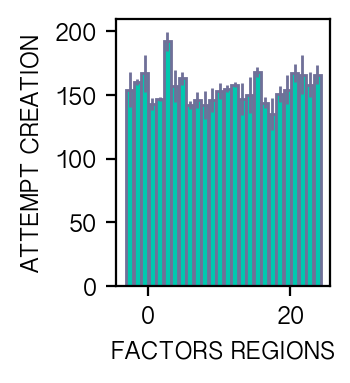

[ERROR]: issue getting x-ticks
   Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Khmer Sangam MN.
[ERROR]: issue getting x-ticks
   Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Khmer Sangam MN.
[ERROR]: issue getting x-ticks
   Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Khmer Sangam MN.
[ERROR]: issue getting x-ticks
   Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Khmer Sangam MN.
[ERROR]: issue getting x-ticks
   Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Khmer Sangam MN.
[ERROR]: issue getting x-ticks
   Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Khmer Sangam MN.
[ERROR]: issue getting x-ticks
   Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Khmer Sangam MN.
[ERROR]: issue getting x-ticks
   Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Khmer Sangam MN.
[ERROR]: issue getting x-ticks
   Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Khmer Sangam MN.
[ERROR]: issue getting x-ticks
   Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Khmer Sangam MN.


<Figure size 640x480 with 0 Axes>

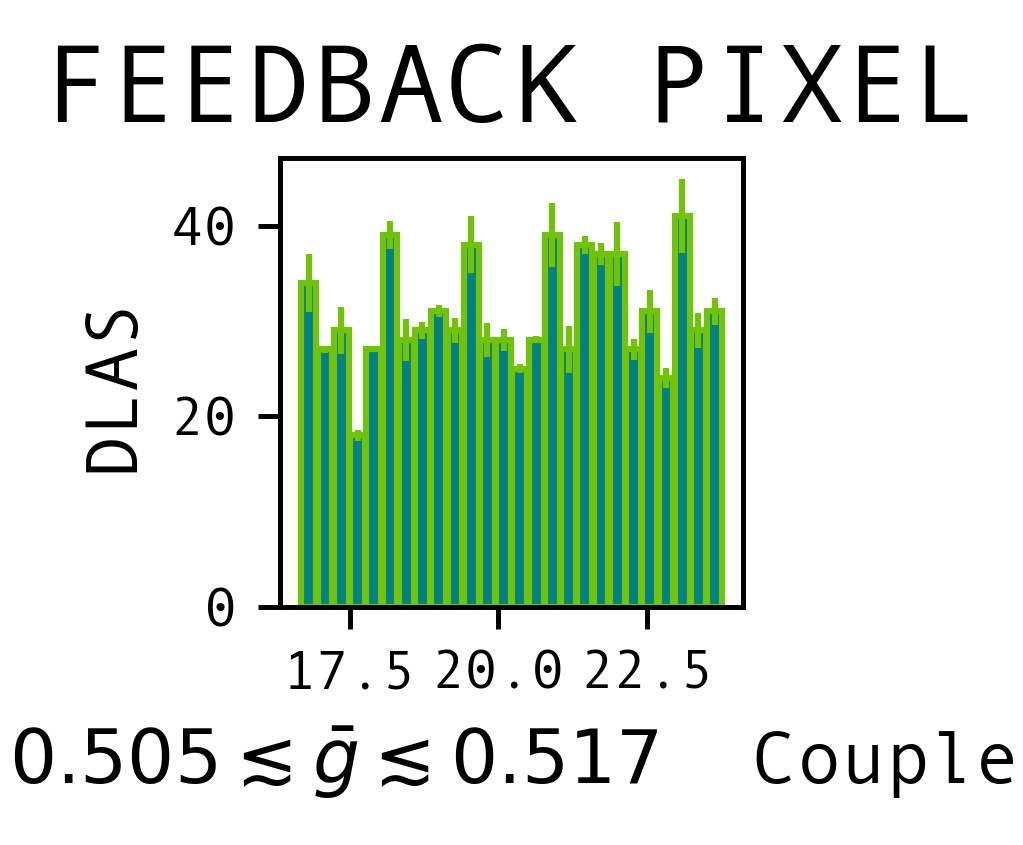

[ERROR]: x/y axis off page, making smaller...
   x/y axis labels: $0.505 \lesssim \bar{g} \lesssim 0.517$  Couple DLAS
   new fontsizes (x,y): 11 11
[ERROR]: title axis off page, making smaller...
   new fontsize: 17
xmin, xmax =  -16.75719858714442 83.20265980256134
figsize (w,h) = (1.918900075935932, 2)


<Figure size 640x480 with 0 Axes>

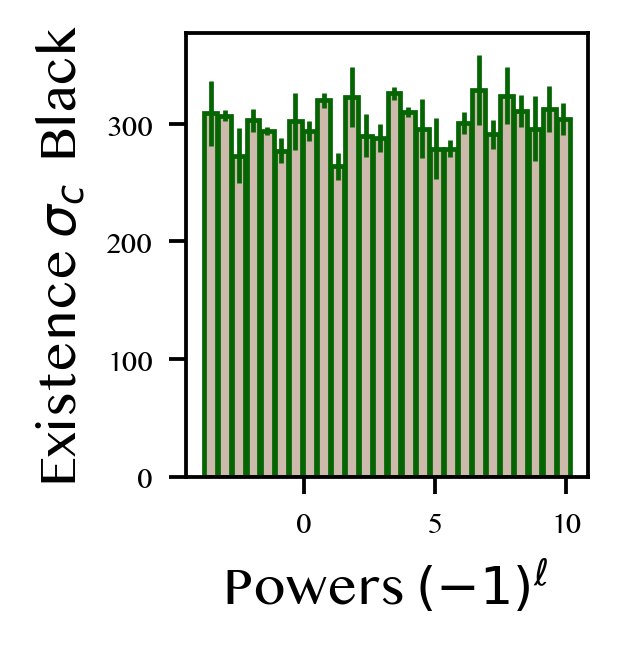

[ERROR]: issue getting x-ticks
   Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Tamil MN.
--- maxed out tries, plot failed ---
seed_outer = 4899858234788625579
seed, inner =  7909574969231846423
seed_titles: 6930367015080195351
seed_font: 47583926255840026
seed_aspect: 678724583155041774

*************** Figure 4 ****************
seed_outer = 1688944623038537976
seed, inner =  6550175595074159921
seed_titles: 42001118249090621
seed_font: 1809694247105909566
seed_aspect: 4414971008630846293
Distribution Type: linear
xmin, xmax =  -6.305029072035415 11.463381424471649
figsize (w,h) = (3.282438259189058, 2)


<Figure size 640x480 with 0 Axes>

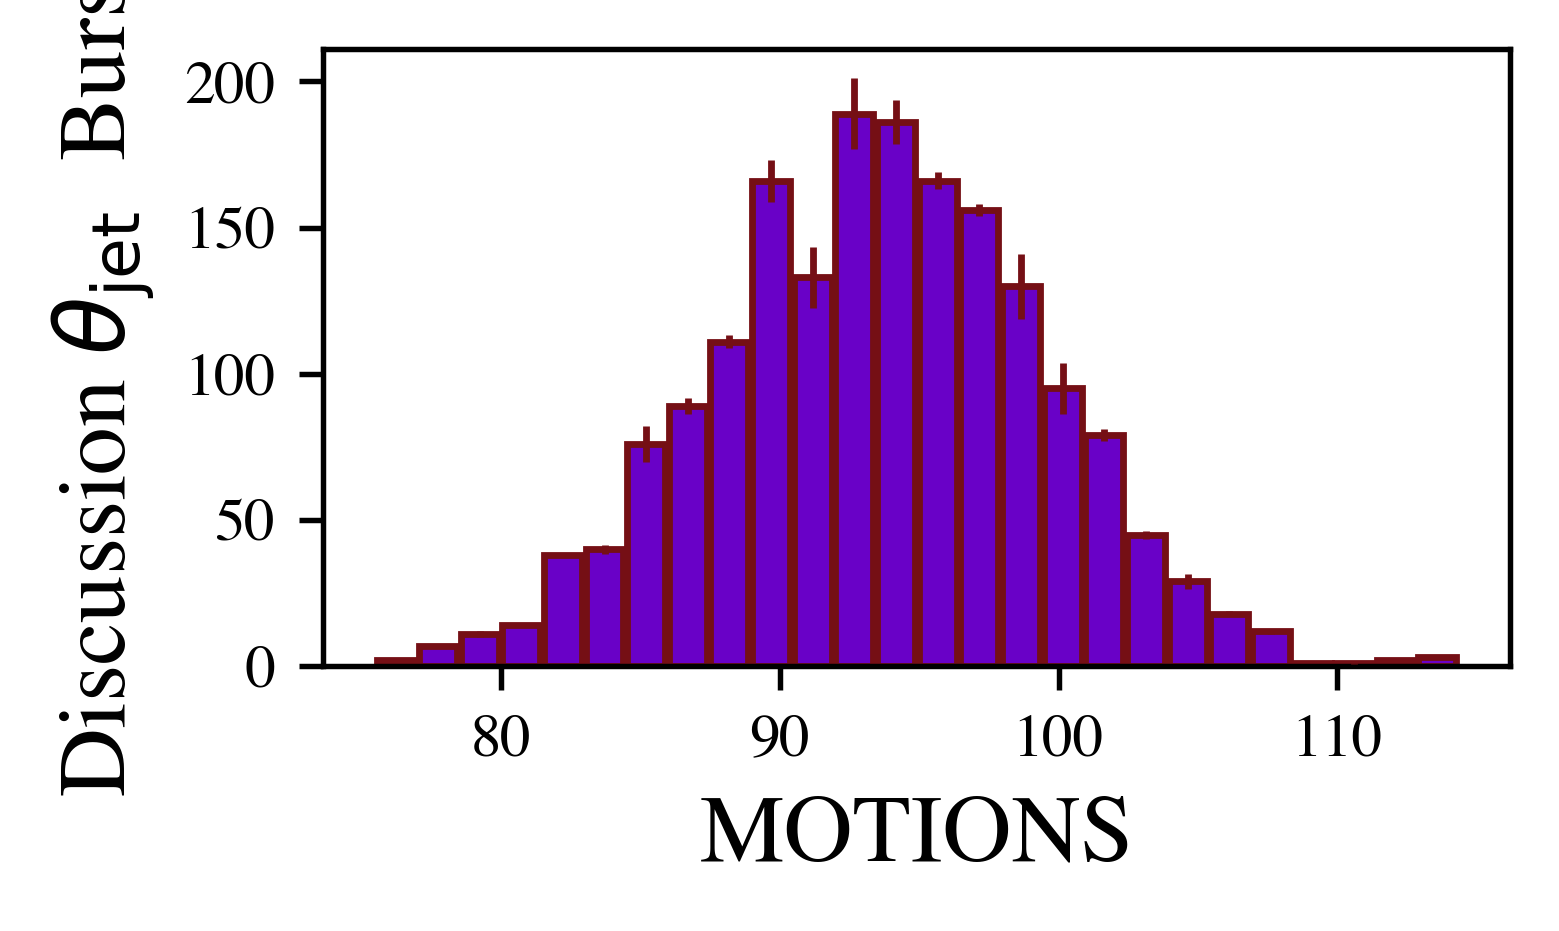

[ERROR]: x/y axis off page, making smaller...
   x/y axis labels: MOTIONS Discussion $\theta_{\rm jet}$  Bursts
   new fontsizes (x,y): 13 13
figsize (w,h) = (3.282438259189058, 2)


<Figure size 640x480 with 0 Axes>

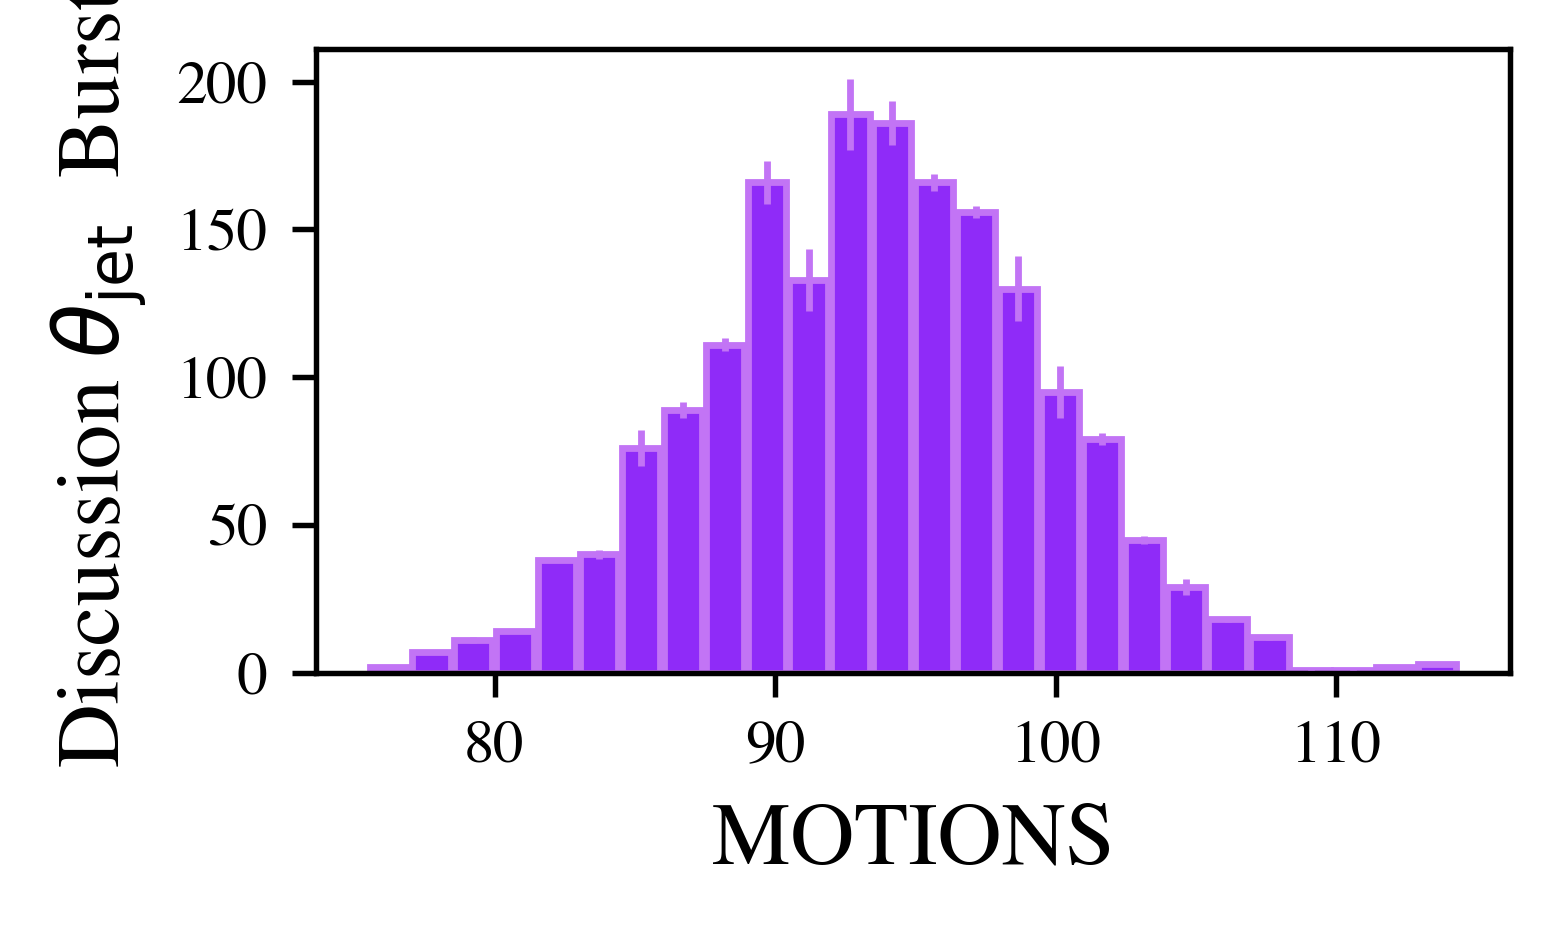

[ERROR]: x/y axis off page, making smaller...
   x/y axis labels: MOTIONS Discussion $\theta_{\rm jet}$  Bursts
   new fontsizes (x,y): 12 12
figsize (w,h) = (3.282438259189058, 2)


<Figure size 640x480 with 0 Axes>

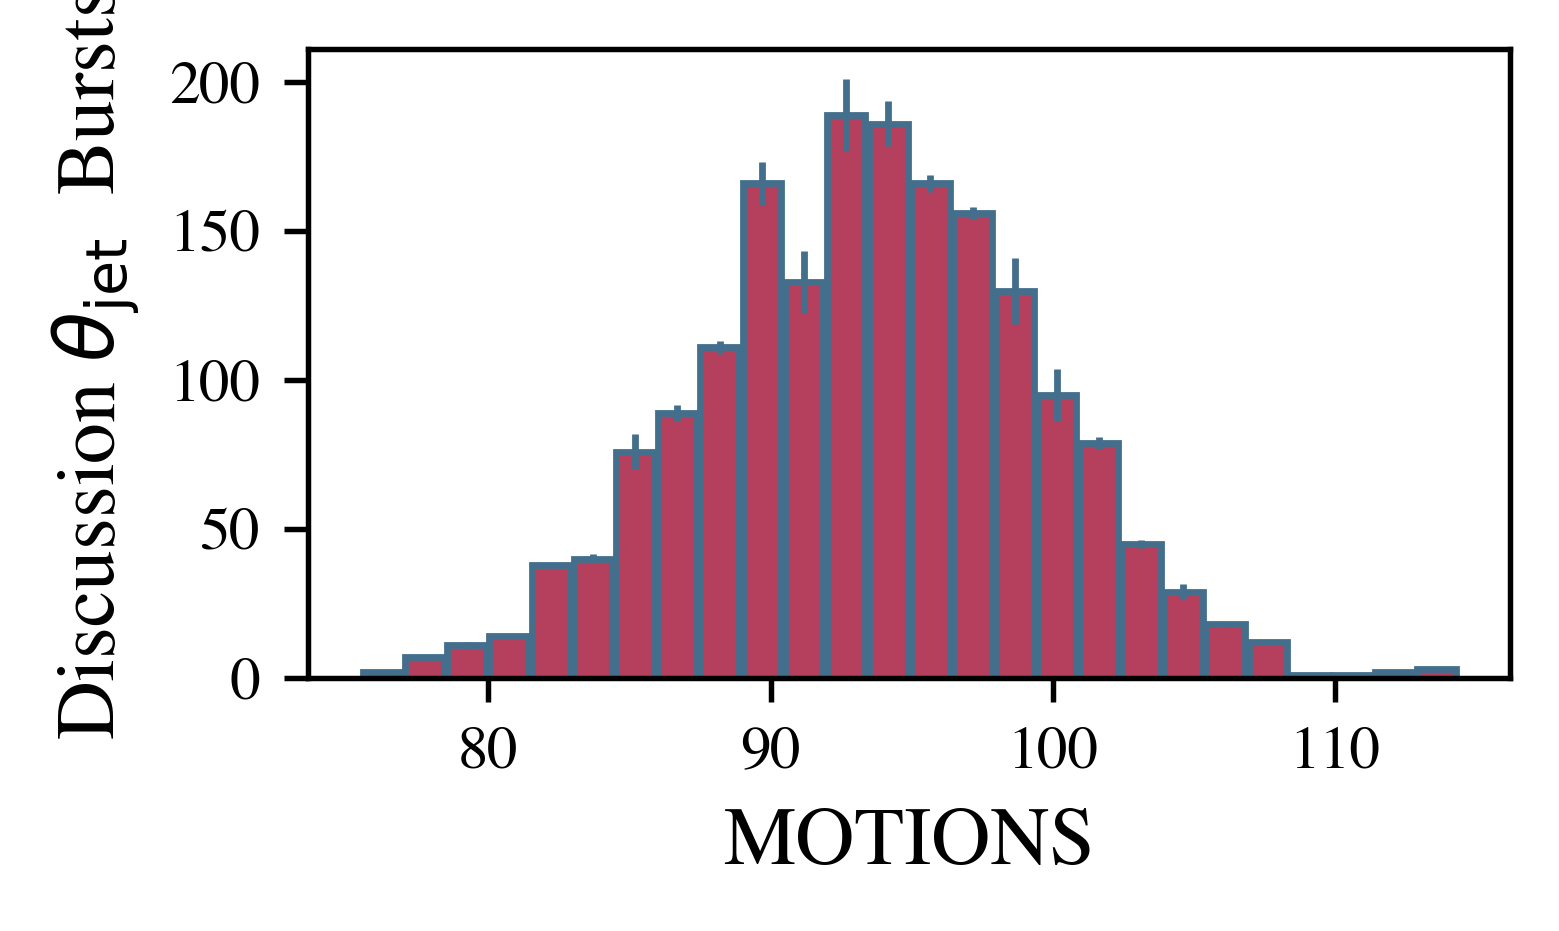

saved: /Users/jnaiman/Downloads/tmp/JCDL2025/visual_qa_histograms/example_hists_complex/imgs/Picture000005.jpeg
 ------ Plot #0 ------ 
Plot type:histogram
Distribution:linear
m * x + b: m & b = 0.9277532760021112 & 91.4467915290651

SUCCESS
QUESTION: You are a helpful assistant that can analyze images.  How many bars are there in the specified figure panel? Please format the output as a json as {"nbars":""} for this figure panel, where the "nbars" value should be an integer.
ANSWER: {'nbars': 26}
QUESTION: You are a helpful assistant that can analyze images.  What is the minimum value of the data in this figure panel?  Please format the output as a json as {"minimum x":""} for this figure panel, where the "minimum x" value should be a float, calculated from the data values used to create the plot.
ANSWER: {'minimum': {'plot0': {'minimum x': 75.50002169698334}}}
QUESTION: You are a helpful assistant that can analyze images.  What is the maximum value of the data in this figure panel?  

<Figure size 640x480 with 0 Axes>

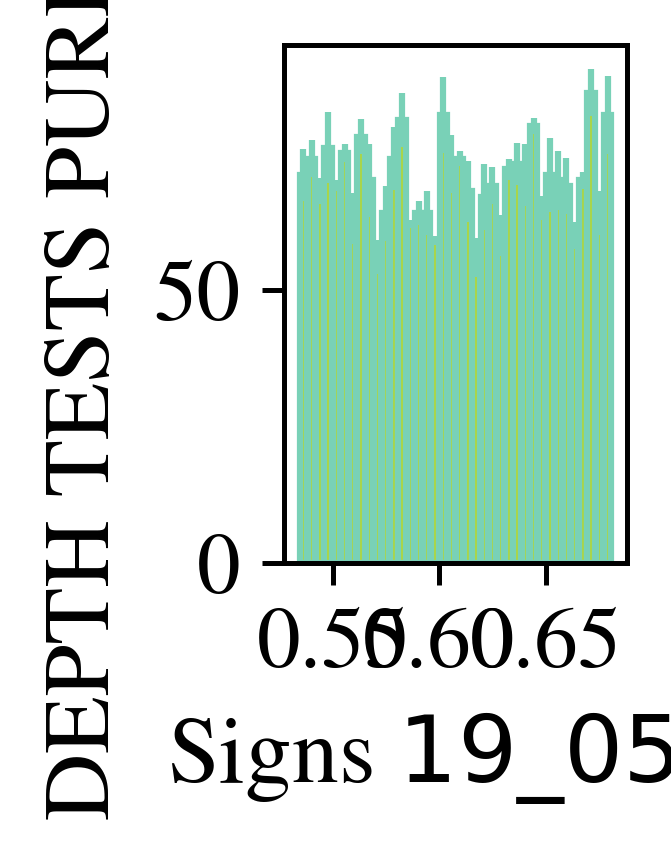

[ERROR]: x/y axis off page, making smaller...
   x/y axis labels: Signs $19\_058$  DEPTH TESTS PURPOSE
   new fontsizes (x,y): 14 14
figsize (w,h) = (1.5992033950682933, 2)


<Figure size 640x480 with 0 Axes>

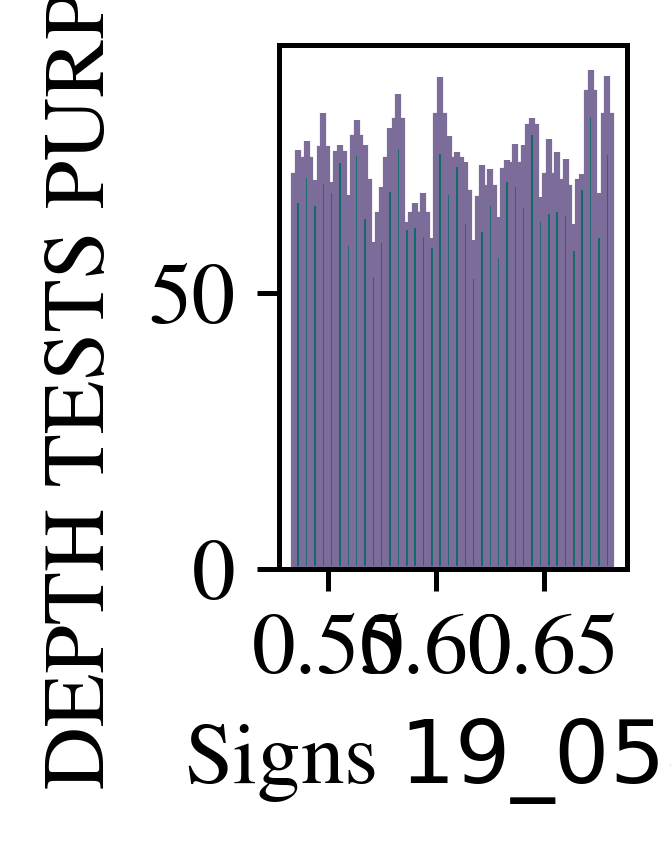

[ERROR]: x/y axis off page, making smaller...
   x/y axis labels: Signs $19\_058$  DEPTH TESTS PURPOSE
   new fontsizes (x,y): 13 13
figsize (w,h) = (1.5992033950682933, 2)


<Figure size 640x480 with 0 Axes>

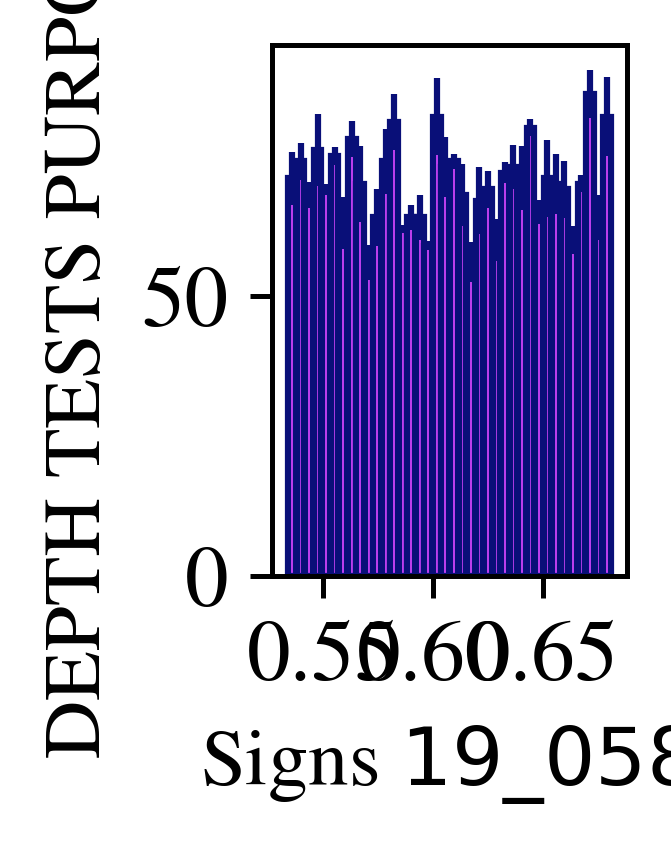

[ERROR]: x/y axis off page, making smaller...
   x/y axis labels: Signs $19\_058$  DEPTH TESTS PURPOSE
   new fontsizes (x,y): 12 12
figsize (w,h) = (1.5992033950682933, 2)


<Figure size 640x480 with 0 Axes>

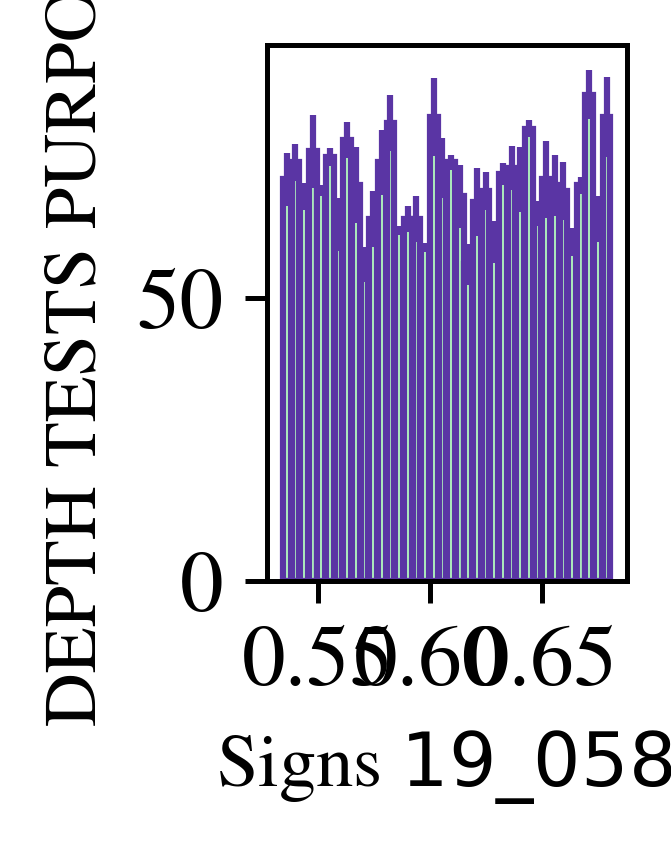

[ERROR]: x/y axis off page, making smaller...
   x/y axis labels: Signs $19\_058$  DEPTH TESTS PURPOSE
   new fontsizes (x,y): 11 11
figsize (w,h) = (1.5992033950682933, 2)


<Figure size 640x480 with 0 Axes>

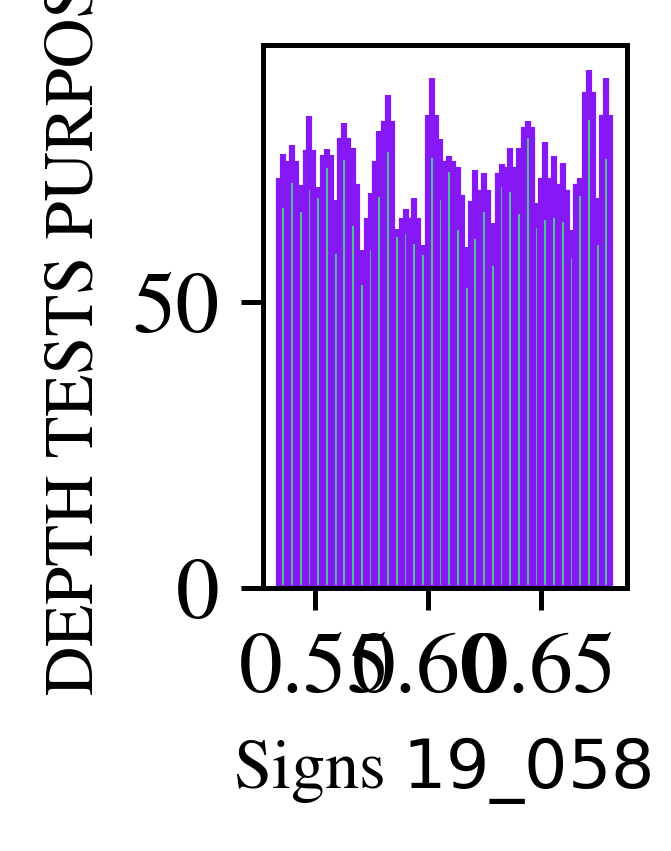

[ERROR]: x/y axis off page, making smaller...
   x/y axis labels: Signs $19\_058$  DEPTH TESTS PURPOSE
   new fontsizes (x,y): 10 10
figsize (w,h) = (1.5992033950682933, 2)


<Figure size 640x480 with 0 Axes>

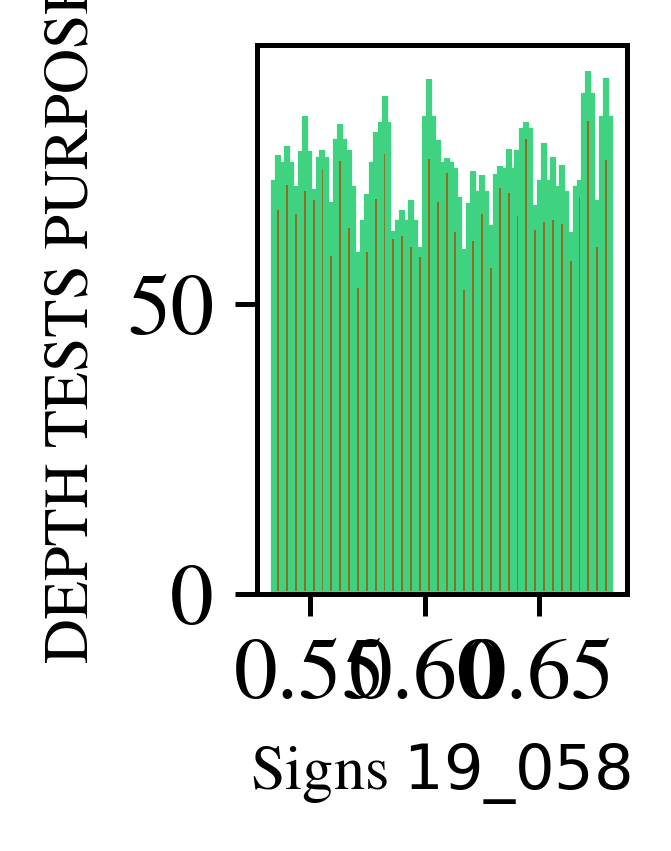

[ERROR]: x/y axis off page, making smaller...
   x/y axis labels: Signs $19\_058$  DEPTH TESTS PURPOSE
   new fontsizes (x,y): 9 9
figsize (w,h) = (1.5992033950682933, 2)


<Figure size 640x480 with 0 Axes>

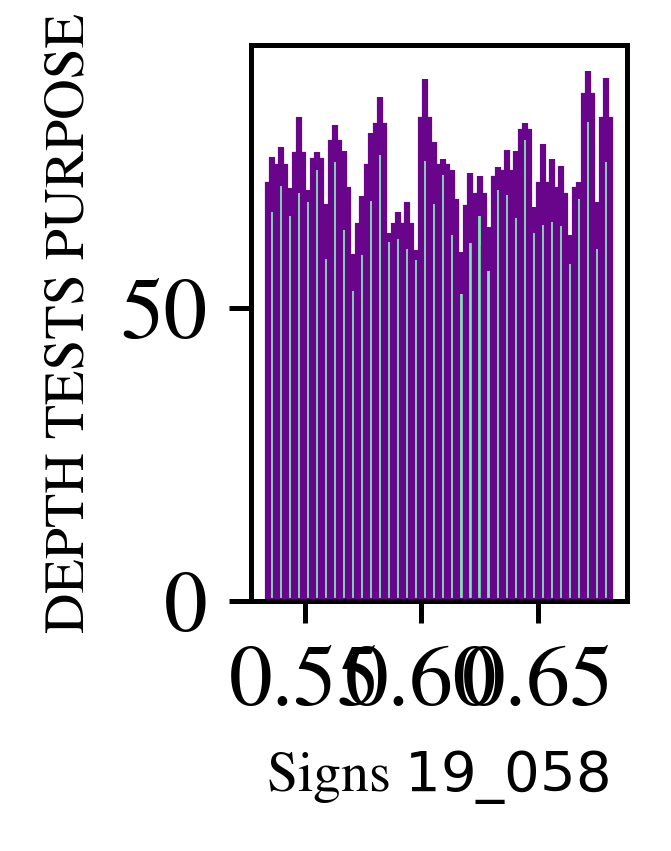

saved: /Users/jnaiman/Downloads/tmp/JCDL2025/visual_qa_histograms/example_hists_complex/imgs/Picture000006.jpeg
 ------ Plot #0 ------ 
Plot type:histogram
Distribution:random

[ERROR]: overlapping boxes!
figsize (w,h) = (1.5992033950682933, 2)


<Figure size 640x480 with 0 Axes>

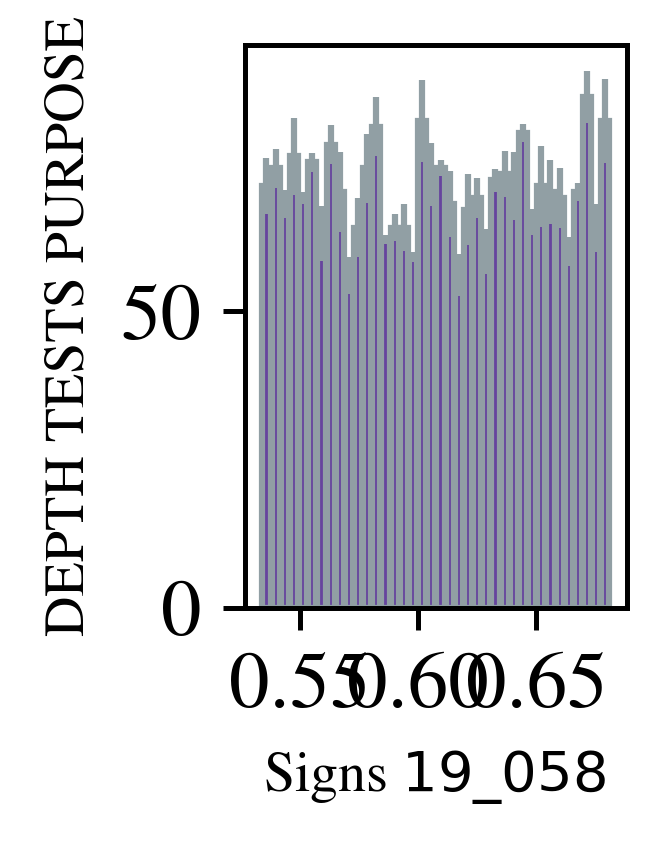

saved: /Users/jnaiman/Downloads/tmp/JCDL2025/visual_qa_histograms/example_hists_complex/imgs/Picture000006.jpeg
 ------ Plot #0 ------ 
Plot type:histogram
Distribution:random

[ERROR]: overlapping boxes!
figsize (w,h) = (1.5992033950682933, 2)


<Figure size 640x480 with 0 Axes>

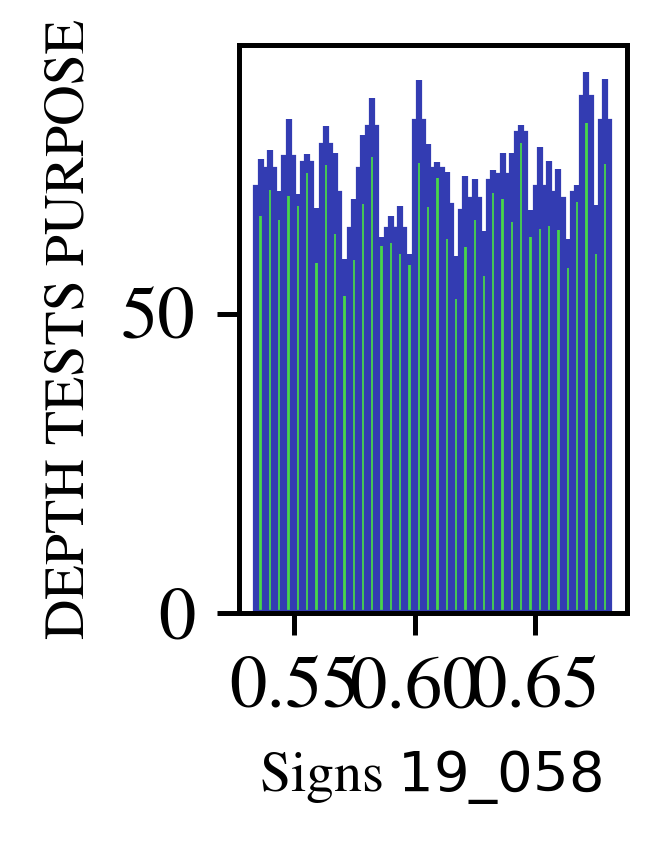

saved: /Users/jnaiman/Downloads/tmp/JCDL2025/visual_qa_histograms/example_hists_complex/imgs/Picture000006.jpeg
 ------ Plot #0 ------ 
Plot type:histogram
Distribution:random

[ERROR]: overlapping boxes!
figsize (w,h) = (1.5992033950682933, 2)


<Figure size 640x480 with 0 Axes>

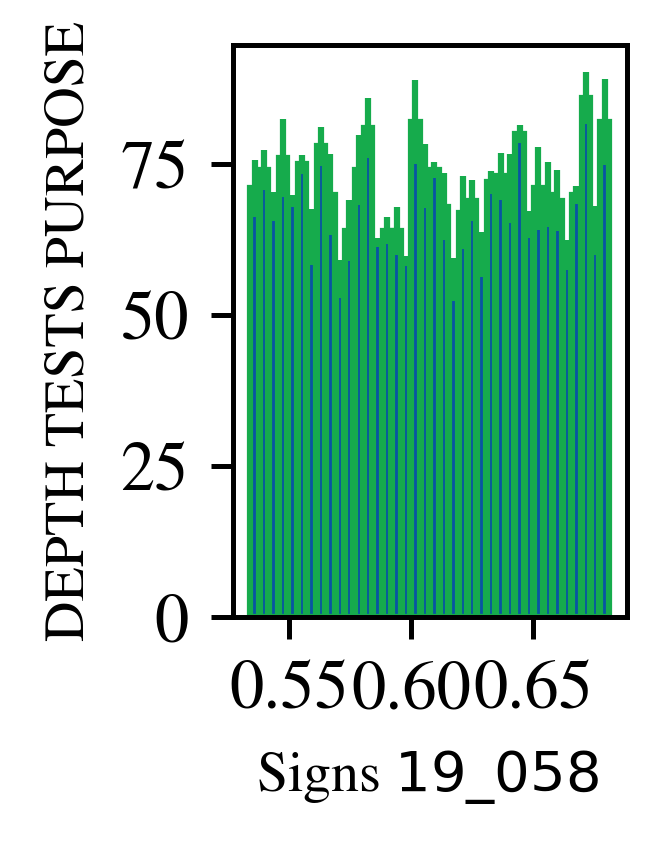

saved: /Users/jnaiman/Downloads/tmp/JCDL2025/visual_qa_histograms/example_hists_complex/imgs/Picture000006.jpeg
 ------ Plot #0 ------ 
Plot type:histogram
Distribution:random

SUCCESS
QUESTION: You are a helpful assistant that can analyze images.  How many bars are there in the specified figure panel? Please format the output as a json as {"nbars":""} for this figure panel, where the "nbars" value should be an integer.
ANSWER: {'nbars': 38}
QUESTION: You are a helpful assistant that can analyze images.  What is the minimum value of the data in this figure panel?  Please format the output as a json as {"minimum x":""} for this figure panel, where the "minimum x" value should be a float, calculated from the data values used to create the plot.
ANSWER: {'minimum': {'plot0': {'minimum x': 0.5340537992644684}}}
QUESTION: You are a helpful assistant that can analyze images.  What is the maximum value of the data in this figure panel?  Please format the output as a json as {"maximum x":""} f

<Figure size 640x480 with 0 Axes>

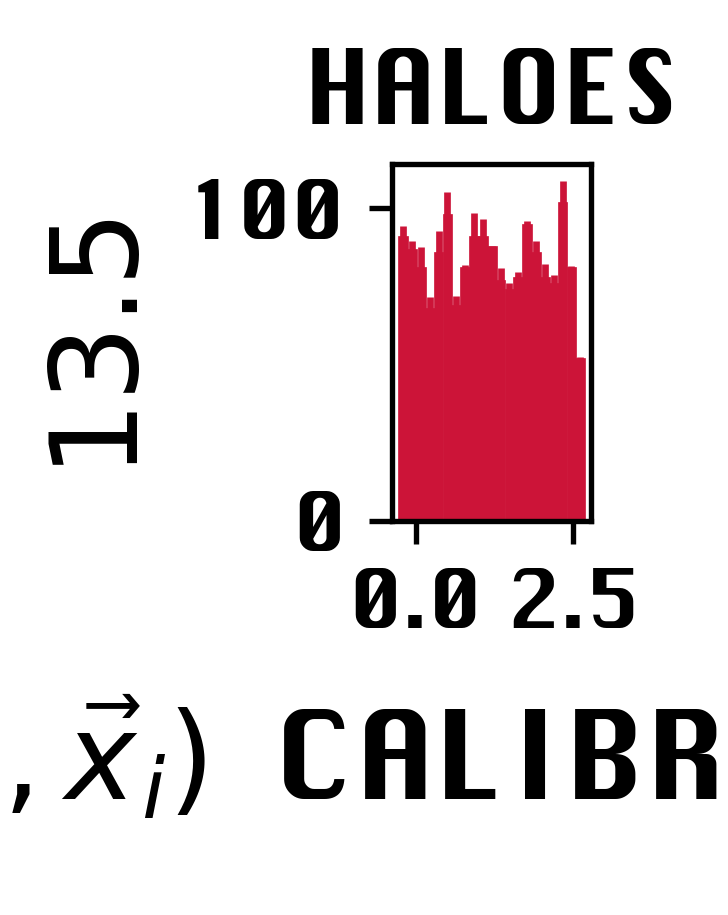

[ERROR]: issue getting x-ticks
   Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Krungthep.
[ERROR]: issue getting x-ticks
   Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Krungthep.
[ERROR]: issue getting x-ticks
   Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Krungthep.
[ERROR]: issue getting x-ticks
   Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Krungthep.
[ERROR]: issue getting x-ticks
   Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Krungthep.
[ERROR]: issue getting x-ticks
   Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Krungthep.
[ERROR]: issue getting x-ticks
   Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Krungthep.
[ERROR]: issue getting x-ticks
   Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Krungthep.
[ERROR]: issue getting x-ticks
   Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Krungthep.
[ERROR]: issue getting x-ticks
   Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Krungthep.
[ERROR]: issue getting x-ticks
   Glyph 8722 (\N{MINUS SIGN}

<Figure size 640x480 with 0 Axes>

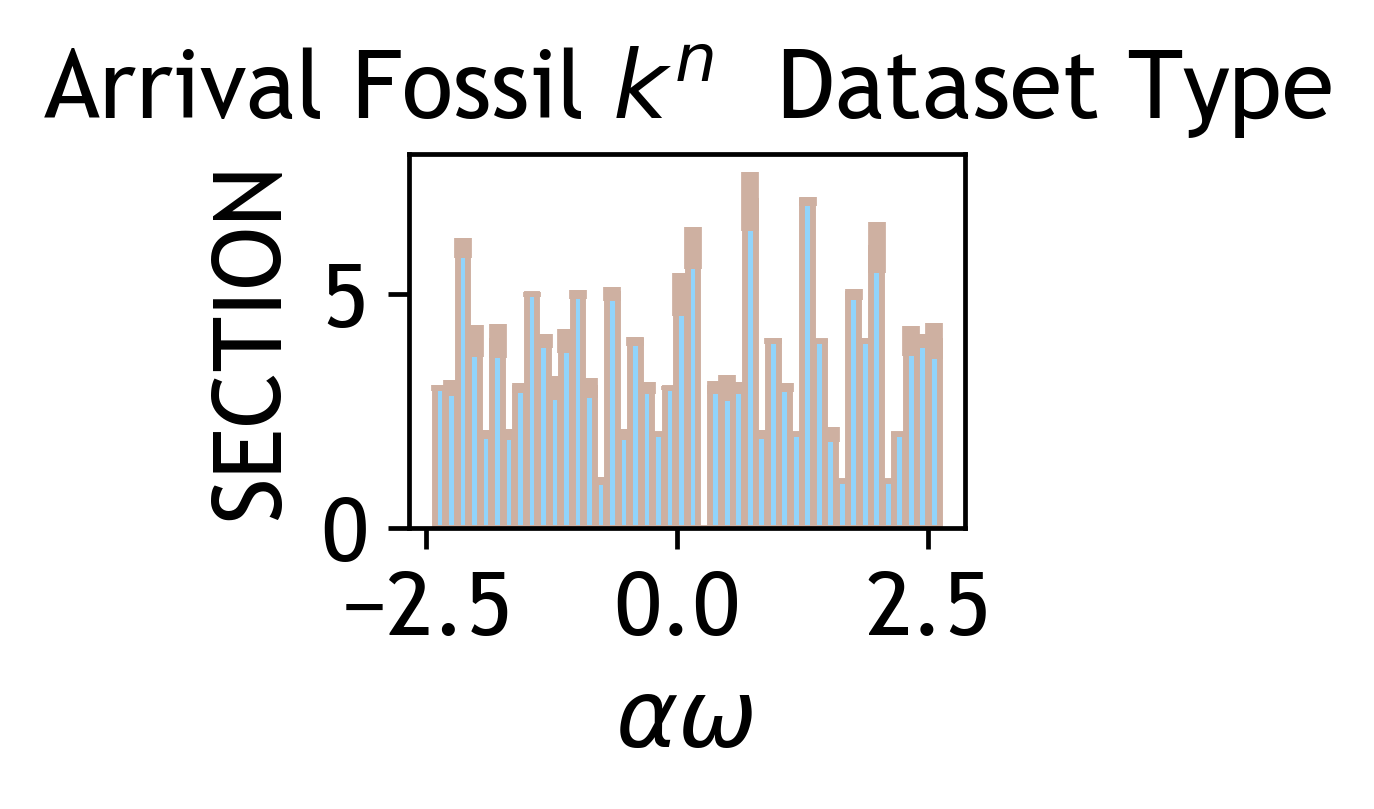

[ERROR]: title axis off page, making smaller...
   new fontsize: 15
xmin, xmax =  -35.08718653820239 3247.93419211731
figsize (w,h) = (2.633313325959204, 2)


<Figure size 640x480 with 0 Axes>

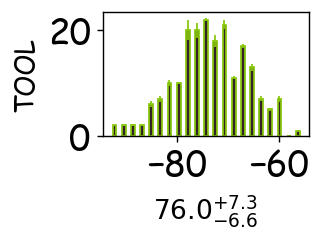

saved: /Users/jnaiman/Downloads/tmp/JCDL2025/visual_qa_histograms/example_hists_complex/imgs/Picture000007.jpeg
 ------ Plot #0 ------ 
Plot type:histogram
Distribution:linear
m * x + b: m & b = 1.1385755044893386 & -73.10910741615632

SUCCESS
QUESTION: You are a helpful assistant that can analyze images.  How many bars are there in the specified figure panel? Please format the output as a json as {"nbars":""} for this figure panel, where the "nbars" value should be an integer.
ANSWER: {'nbars': 21}
QUESTION: You are a helpful assistant that can analyze images.  What is the minimum value of the data in this figure panel?  Please format the output as a json as {"minimum x":""} for this figure panel, where the "minimum x" value should be a float, calculated from the data values used to create the plot.
ANSWER: {'minimum': {'plot0': {'minimum x': -93.14207826533838}}}
QUESTION: You are a helpful assistant that can analyze images.  What is the maximum value of the data in this figure panel

<Figure size 640x480 with 0 Axes>

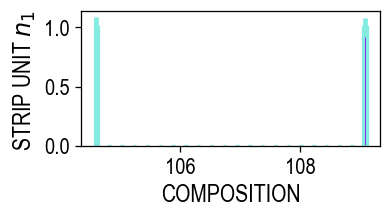

In [ ]:
nHistTotal = 100 # how many to make?
restart = False # set to True to overwrite what is there

grace_ticks = 5 # ignore tick marks that are outside the box by this -- invisible most likely
itriesMax = 100 # start again if too many tries
verbose = True
verbose_qa = True

# some defaults
tight_layout = True
npanels, panel_style, nrows, ncols = 1, 'square', 1, 1 # keep single image
fontsize_min = 8 # minimum to try to shrink titles
aspect_cut = {'min':0.3, 'max':4.0} # start again if the square is within this
ifigure = 0

#for ifigure in range(nHistTotal):
while ifigure < nHistTotal:
    print('')
    if verbose:
        print('*************** Figure', ifigure, '****************')
    # check if there for all formats
    hasFig = []
    for iformat in img_format:
        if os.path.exists(fake_figs_dir + 'imgs/Picture' + str(ifigure+1).zfill(6) + '.'+iformat):
            hasFig.append(iformat)
    # and json
    if os.path.exists(fake_figs_dir + 'jsons/Picture' + str(ifigure+1).zfill(6) + '.json'):
        hasFig.append('json')
    if (len(hasFig) == len(img_format) + 1) and not restart: # extra 1 for json
        if verbose:
            print('  already have:', fake_figs_dir + 'imgs/Picture' + str(ifigure+1).zfill(6) + '.<FMT>')
        ifigure += 1
        continue

    #import sys; sys.exit()
    # set all seeds for this plot
    rng_outer, rng, rng_titles, rng_font, rng_aspect = set_all_seeds(reset_outer = True, 
                                                                     reset_inner = True, 
                                                                     reset_titles=True, 
                                                                     reset_fonts = True, 
                                                                     reset_aspect = True, 
                                                                     verbose=verbose)

    # init plot params
    color_map = rng_outer.choice(plt.colormaps()) # choose a color map
    plot_style = rng_outer.choice(plot_styles) # choose a plotting style
    aspect_fig = rng_outer.uniform(low=aspect_fig_params['min'], high=aspect_fig_params['max'])
    dpi = int(rng_outer.uniform(low=dpi_params['min'], high=dpi_params['max']))

    # get all font stuffs
    title_fontsize, colorbar_fontsize, xlabel_fontsize, ylabel_fontsize, \
        xlabel_ticks_fontsize, ylabel_ticks_fontsize, \
                            csfont = get_font_info(fontsizes, font_names, rng=rng_titles)
    
    # get distribution type
    dist_params = plot_params_out[plot_type]['distribution'] 
    choices_d = []; probs_d = []
    for k,v in dist_params.items():
        choices_d.append(k)
        probs_d.append(v['prob'])

    distribution_type = np.random.choice(choices_d, p=probs_d)
    if verbose: print('Distribution Type:', distribution_type)

    # pull xmin/xmax for hists
    xmin,xmax = log_scale_ax()
    plot_params_out[plot_type]['xmin']=xmin
    plot_params_out[plot_type]['xmax']=xmax
    if verbose: print('xmin, xmax = ', xmin, xmax)

    # get plot data
    success_get_data = False
    while not success_get_data:
        data_for_plot = get_data(plot_params_out[plot_type], 
                                plot_type=plot_type, distribution=distribution_type, rng=rng)
        if len(data_for_plot['xs']) > 0 and plot_type == 'histogram':
            success_get_data = True

    ###### PLOT ########
    success_plot = False # overall plot
    # flags for various things
    success_titles = False
    # keep titles
    xlabels_pull = deepcopy(popular_nouns)
    ylabels_pull = deepcopy(popular_nouns)
    titles_pull = deepcopy(popular_nouns)
    # track figures
    # ifigure = 0
    itries = 0
    while not success_plot and itries <= itriesMax:
        itries += 1
        if itries >= itriesMax: # update everybody
            success_titles, rng_aspect, rng_titles, aspect_fig, xlabels_pull, ylabels_pull, \
                    titles_pull, rng_outer, color_map, plot_style, dist_params, distribution_type, \
                    title_fontsize, colorbar_fontsize, xlabel_fontsize, ylabel_fontsize, \
                    xlabel_ticks_fontsize, ylabel_ticks_fontsize, \
                                    csfont, dpi, xmin,xmax, \
                                        plot_params_in, data_for_plot = reset_all_params(plot_params_out, 
                                                                                         popular_nouns, 
                                                                                         plot_styles, 
                                                                                         fontsizes, 
                                                                                         font_names, 
                                                                                         dpi_params)
            success_plot = False
            # get plot data
            success_get_data = False
            while not success_get_data:
                data_for_plot = get_data(plot_params_out[plot_type], 
                                        plot_type=plot_type, distribution=distribution_type, rng=rng)
                if len(data_for_plot['xs']) > 0 and plot_type == 'histogram':
                    success_get_data = True

        rng = np.random.default_rng(seed)
        while not success_titles: # ensure we catch any errors with bad fonts
            try:
                # make figure object
                fig, axes, plot_inds = make_base_plot(plot_style, color_map, dpi, nrows, ncols, aspect_fig,
                                base=2, verbose=True, tight_layout = tight_layout)
                # make plot based on data we already got
                data_from_plot, ax = make_plot(plot_params_out[plot_type], data_for_plot, 
                                        axes[0], plot_type=plot_type, linestyles=linestyles_hist, 
                                        rng=rng)
                # generate x/y labels and titles
                title, xlabel, ylabel = add_titles_and_labels(axes[0], xlabels_pull, ylabels_pull, titles_pull, 
                                                        title_params, csfont, title_fontsize, 
                                    xlabel_params, ylabel_params, xlabel_fontsize, ylabel_fontsize,
                                    inlines, xlabel_ticks_fontsize, ylabel_ticks_fontsize,
                                    rng=rng_titles)
                # set "pulls" to save, reset letter as needed
                try:
                    xlabels_pull = xlabel.get_text()
                except:
                    if type(xlabel) == type([]) or type(xlabel) == type('hi'):
                        xlabels_pull = xlabel
                    else:
                        lfkasjl
                try:
                    ylabels_pull = ylabel.get_text()
                except:
                    if type(ylabel) == type([]) or type(ylabel) == type('hi'):
                        ylabels_pull = ylabel
                    else:
                        flasj
                try:
                    titles_pull = title.get_text()
                except:
                    if type(title) == type([]) or type(title) == type('hi'):
                        titles_pull = title
                    else:
                        flasj
                # flag as success after render      
                success_titles = True
                plt.draw()
                plt.pause(0.001)
            except Exception as e:
                plt.close('all')
                #print("HERE")
                if 'missing from font' in str(e):
                    print('[ERROR]: missing font (' + str(e) + '), will try with new font')
                    seed_font = np.random.randint(maxint)
                    rng_font = np.random.default_rng(seed_font)
                    try:
                        _, _, _, _, _, _, csfont = get_font_info(fontsizes, font_names, rng=rng_font)
                    except Exception as e2:
                        pass
                    success_titles = False
                elif 'Tight layout not applied' in str(e): # issue with tight layout, redo
                    print('[ERROR]: tight layout not applied - ', str(e))
                    # rng_outer, rng, rng_titles, rng_font, rng_aspect = set_all_seeds(reset_outer = True, 
                    #                                                  reset_inner = True, 
                    #                                                  reset_titles=True, 
                    #                                                  reset_fonts = True, 
                    #                                                  reset_aspect = True, 
                    #                                                  verbose=verbose)
                    # # success_titles, rng_aspect, rng_titles, aspect_fig, xlabels_pull, ylabels_pull, \
                    # #     titles_pull, rng_outer, color_map, plot_style, dist_params, distribution_type, \
                    # # title_fontsize, colorbar_fontsize, xlabel_fontsize, ylabel_fontsize, \
                    # #     xlabel_ticks_fontsize, ylabel_ticks_fontsize, \
                    # #                         csfont, dpi = reset_all_params()
                    # success_plot = False
                    # success_titles = False
                    success_titles, rng_aspect, rng_titles, aspect_fig, xlabels_pull, ylabels_pull, \
                            titles_pull, rng_outer, color_map, plot_style, dist_params, distribution_type, \
                            title_fontsize, colorbar_fontsize, xlabel_fontsize, ylabel_fontsize, \
                            xlabel_ticks_fontsize, ylabel_ticks_fontsize, \
                                            csfont, dpi, xmin,xmax, \
                                                plot_params_in, data_for_plot = reset_all_params(plot_params_out, 
                                                                                                popular_nouns, 
                                                                                                plot_styles, 
                                                                                                fontsizes, 
                                                                                                font_names, 
                                                                                                dpi_params)
                else:
                    if verbose: print('[ERROR]: other error - ', str(e))
                    success_titles, rng_aspect, rng_titles, aspect_fig, xlabels_pull, ylabels_pull, \
                            titles_pull, rng_outer, color_map, plot_style, dist_params, distribution_type, \
                            title_fontsize, colorbar_fontsize, xlabel_fontsize, ylabel_fontsize, \
                            xlabel_ticks_fontsize, ylabel_ticks_fontsize, \
                                            csfont, dpi, xmin,xmax, \
                                                plot_params_in, data_for_plot = reset_all_params(plot_params_out, 
                                                                                                popular_nouns, 
                                                                                                plot_styles, 
                                                                                                fontsizes, 
                                                                                                font_names, 
                                                                                                dpi_params)
                    # rng_outer, rng, rng_titles, rng_font, rng_aspect = set_all_seeds(reset_outer = True, 
                    #                                                  reset_inner = True, 
                    #                                                  reset_titles=True, 
                    #                                                  reset_fonts = True, 
                    #                                                  reset_aspect = True, 
                    #                                                  verbose=verbose)
                    # success_titles = False
                    # #laslfjasl
                    # # success_titles, rng_aspect, rng_titles, aspect_fig, xlabels_pull, ylabels_pull, \
                    # #     titles_pull, rng_outer, color_map, plot_style, dist_params, distribution_type, \
                    # # title_fontsize, colorbar_fontsize, xlabel_fontsize, ylabel_fontsize, \
                    # #     xlabel_ticks_fontsize, ylabel_ticks_fontsize, \
                    # #                         csfont, dpi = reset_all_params()
                    # success_plot = False
                #continue

        ###### SAVE FIG and collect bounding boxes #####
        plt.set_cmap(color_map) # do again
        #success_tight = True
        try:
            fig.tight_layout()
            #success_tight = False
        except Exception as e_tight2:
            if verbose: print('[ERROR]: tight layout 2 -- ', str(e_tight2))
            success_titles, rng_aspect, rng_titles, aspect_fig, xlabels_pull, ylabels_pull, \
                    titles_pull, rng_outer, color_map, plot_style, dist_params, distribution_type, \
                    title_fontsize, colorbar_fontsize, xlabel_fontsize, ylabel_fontsize, \
                    xlabel_ticks_fontsize, ylabel_ticks_fontsize, \
                                    csfont, dpi, xmin,xmax, \
                                        plot_params_in, data_for_plot = reset_all_params(plot_params_out, 
                                                                                         popular_nouns, 
                                                                                         plot_styles, 
                                                                                         fontsizes, 
                                                                                         font_names, 
                                                                                         dpi_params)
            # rng_outer, rng, rng_titles, rng_font, rng_aspect = set_all_seeds(reset_outer = True, 
            #                                                          reset_inner = True, 
            #                                                          reset_titles=True, 
            #                                                          reset_fonts = True, 
            #                                                          reset_aspect = True, 
            #                                                          verbose=verbose)
            # success_titles = False
            # # success_titles, rng_aspect, rng_titles, aspect_fig, xlabels_pull, ylabels_pull, \
            # #     titles_pull, rng_outer, color_map, plot_style, dist_params, distribution_type, \
            # #     title_fontsize, colorbar_fontsize, xlabel_fontsize, ylabel_fontsize, \
            # #     xlabel_ticks_fontsize, ylabel_ticks_fontsize, \
            # #                         csfont, dpi = reset_all_params()
            # # success_plot = False

        if not success_titles:
            continue

        # collect data
        try:
            fig.canvas.draw()
        except Exception as e_draw:
            if verbose: print('[ERROR]: in fig.canvas.draw -- ', str(e_draw))
            success_titles, rng_aspect, rng_titles, aspect_fig, xlabels_pull, ylabels_pull, \
                    titles_pull, rng_outer, color_map, plot_style, dist_params, distribution_type, \
                    title_fontsize, colorbar_fontsize, xlabel_fontsize, ylabel_fontsize, \
                    xlabel_ticks_fontsize, ylabel_ticks_fontsize, \
                                    csfont, dpi, xmin,xmax, \
                                        plot_params_in, data_for_plot = reset_all_params(plot_params_out, 
                                                                                         popular_nouns, 
                                                                                         plot_styles, 
                                                                                         fontsizes, 
                                                                                         font_names, 
                                                                                         dpi_params)
            # success_titles, rng_aspect, rng_titles, aspect_fig, xlabels_pull, ylabels_pull, \
            #     titles_pull, rng_outer, color_map, plot_style, dist_params, distribution_type, \
            #     title_fontsize, colorbar_fontsize, xlabel_fontsize, ylabel_fontsize, \
            #     xlabel_ticks_fontsize, ylabel_ticks_fontsize, \
            #                         csfont, dpi = reset_all_params()
            # success_plot = False
            # rng_outer, rng, rng_titles, rng_font, rng_aspect = set_all_seeds(reset_outer = True, 
            #                                                          reset_inner = True, 
            #                                                          reset_titles=True, 
            #                                                          reset_fonts = True, 
            #                                                          reset_aspect = True, 
            #                                                          verbose=verbose)
            # success_titles = False
        if not success_titles:
            continue

        width, height = fig.canvas.get_width_height()
        # save data
        datas = {}
        # figure datas
        success_fill_data = False
        datas['figure'] = {'dpi':dpi, 'base':base, 'aspect ratio': aspect_fig, 
                            'nrows':nrows, 'ncols':ncols, 
                            'plot style':plot_style, 
                            'color map':color_map,
                            'title fontsize':title_fontsize, 
                            'xlabel fontsize':xlabel_fontsize,
                            'ylabel fontsize':ylabel_fontsize, 
                        'plot indexes':plot_inds}
        try:
            for iplot,ax in enumerate(axes): ### XYZ, only 1 axis here
                datas['plot' + str(iplot)], err = collect_plot_data_axes(ax, fig,
                                height, width,
                                data_from_plot, data_for_plot, 
                                plot_type, title, 
                                xlabel, ylabel,
                                distribution_type, verbose=True, error_out=False)
            if not err: success_fill_data = True
        except Exception as e_fill_data:
            if verbose:
                print('[ERROR]: ' + str(e_fill_data))
            if 'Glyph' in str(e_fill_data) and 'missing' in str(e_fill_data): # missing a glyph, try different font
                _, _, _, rng_font, _ = set_all_seeds(reset_fonts = True, verbose=verbose)
            else: # no idea! reset everybody
                success_titles, rng_aspect, rng_titles, aspect_fig, xlabels_pull, ylabels_pull, \
                    titles_pull, rng_outer, color_map, plot_style, dist_params, distribution_type, \
                    title_fontsize, colorbar_fontsize, xlabel_fontsize, ylabel_fontsize, \
                    xlabel_ticks_fontsize, ylabel_ticks_fontsize, \
                                    csfont, dpi, xmin,xmax, \
                                        plot_params_in, data_for_plot = reset_all_params(plot_params_out, 
                                                                                         popular_nouns, 
                                                                                         plot_styles, 
                                                                                         fontsizes, 
                                                                                         font_names, 
                                                                                         dpi_params)
                # rng_outer, rng, rng_titles, rng_font, rng_aspect = set_all_seeds(reset_outer = True, 
                #                                                      reset_inner = True, 
                #                                                      reset_titles=True, 
                #                                                      reset_fonts = True, 
                #                                                      reset_aspect = True, 
                #                                                      verbose=verbose)
                # success_titles = False

        if not success_fill_data or not success_titles:
            continue
            

        ########### CHECKS -- titles off, bounding boxes, etc ##########
        # 1. Check for square with weird aspect ratio
        success_titles, success_aspect, aspect_fig = check_aspect(datas, success_titles, aspect_fig)
        if not success_aspect:
            continue

        # 2. Check if titles or x/y axis labels are running off the page         
        success_titles, xlabel_fontsize, ylabel_fontsize, title_fontsize, \
            xlabels_pull, ylabels_pull, titles_pull, rng_titles, \
                success_title_label, success_axis_labels = check_labels_titles_off_page(datas, width, height, success_titles, 
                                    xlabels_pull, ylabels_pull, titles_pull, 
                                    xlabel_fontsize, ylabel_fontsize, rng_titles, 
                                    popular_nouns, title_fontsize, 
                                    fontsize_min = fontsize_min, verbose=verbose)

        if not success_title_label or not success_axis_labels:
            continue
                

        # 3. Save the fig, check if we have issues opening it
        # for diagnostics! -- move to after success of fig!
        success_save = False
        try:
            for iformat in img_format:
                fig.savefig(fake_figs_dir + 'imgs/Picture' + str(ifigure+1).zfill(6) + '.'+iformat, dpi=dpi)#, bbox_inches='tight')
                print('saved:', fake_figs_dir + 'imgs/Picture' + str(ifigure+1).zfill(6) + '.'+iformat)
            success_save = True
        except Exception as e_save:
            print('[ERROR]: could not save fig --', str(e_save))
            success_titles, rng_aspect, rng_titles, aspect_fig, xlabels_pull, ylabels_pull, \
                    titles_pull, rng_outer, color_map, plot_style, dist_params, distribution_type, \
                    title_fontsize, colorbar_fontsize, xlabel_fontsize, ylabel_fontsize, \
                    xlabel_ticks_fontsize, ylabel_ticks_fontsize, \
                                    csfont, dpi, xmin,xmax, \
                                        plot_params_in, data_for_plot = reset_all_params(plot_params_out, 
                                                                                         popular_nouns, 
                                                                                         plot_styles, 
                                                                                         fontsizes, 
                                                                                         font_names, 
                                                                                         dpi_params)
            # rng_outer, rng, rng_titles, rng_font, rng_aspect = set_all_seeds(reset_outer = True, 
            #                                                          reset_inner = True, 
            #                                                          reset_titles=True, 
            #                                                          reset_fonts = True, 
            #                                                          reset_aspect = True, 
            #                                                          verbose=verbose)
            # success_titles = False
        if not success_save or not success_titles:
            continue
        # check if issue opening plot
        e = ''
        try:
            for iformat in img_format:
                img = np.array(Image.open(fake_figs_dir + 'imgs/Picture' + str(ifigure+1).zfill(6) + '.'+iformat))
        except Exception as e:
            #success_titles = False
            # redo_gen_fig = True
            # redo_gen_plot = True
            success_titles, rng_aspect, rng_titles, aspect_fig, xlabels_pull, ylabels_pull, \
                    titles_pull, rng_outer, color_map, plot_style, dist_params, distribution_type, \
                    title_fontsize, colorbar_fontsize, xlabel_fontsize, ylabel_fontsize, \
                    xlabel_ticks_fontsize, ylabel_ticks_fontsize, \
                                    csfont, dpi, xmin,xmax, \
                                        plot_params_in, data_for_plot = reset_all_params(plot_params_out, 
                                                                                         popular_nouns, 
                                                                                         plot_styles, 
                                                                                         fontsizes, 
                                                                                         font_names, 
                                                                                         dpi_params)
            if verbose: 
                print('[ERROR]: Issue with opening image!')
                if str(e) != '': print('Full error:', str(e))
            # rng_outer, rng, rng_titles, rng_font, rng_aspect = set_all_seeds(reset_outer = True, 
            #                                                          reset_inner = True, 
            #                                                          reset_titles=True, 
            #                                                          reset_fonts = True, 
            #                                                          reset_aspect = True, 
            #                                                          verbose=verbose)
        if not success_titles:
            continue


        # 4. Check if any bounding boxes are overlapping
        success_boxes, boxes_check, names_overlap = collect_boxes(datas, grace_ticks=grace_ticks)

        if save_diagnostic_plot:
            img_diag = np.array(Image.open(fake_figs_dir + 'imgs/Picture' + str(ifigure+1).zfill(6) + '.'+img_format[0]).convert('RGB'))
            imgplot = add_annotations(img_diag, img_diag, deepcopy(datas))            

        if not success_boxes: # check who overlaps with who
            success_titles, xlabel_fontsize, ylabel_fontsize, ylabel_ticks_fontsize, \
                xlabel_ticks_fontsize, title_fontsize, xlabels_pull, \
                    ylabels_pull, titles_pull, rng_titles = update_fonts_boxes_overlap(names_overlap, success_titles, rng_titles,popular_nouns,
                                    xlabels_pull, ylabels_pull, titles_pull,
                                xlabel_ticks_fontsize, ylabel_ticks_fontsize, 
                                xlabel_fontsize, ylabel_fontsize, title_fontsize,
                                verbose=verbose, fontsize_min=fontsize_min)
            continue


        success_plot = True # hurray if we've made it this far!
        # if all went well, reset seed
        seed = np.random.randint(maxint)

        print('SUCCESS')
        plt.close(fig)

        ######## GENERATE QA BASE #######
        qa_pairs = init_qa_pairs()
        for iplot in range(len((axes))):
            if datas['plot'+str(iplot)]['type'] == 'histogram':
                ############ L1 #############
                # number of bars
                if len(axes) > 1:
                    qa_pairs = q_nbars_hist_plot_plotnums(datas, qa_pairs, plot_num = iplot, use_words=False, verbose=verbose_qa)
                qa_pairs = q_nbars_hist_plot_plotnums(datas, qa_pairs, plot_num = iplot, use_words=True, verbose=verbose_qa)

                ###### L2 #######
                # stats items
                for k,v in stats.items():
                    if len(axes) > 1:
                        qa_pairs = q_stats_hists(datas, qa_pairs, stat={k:v}, plot_num=iplot, use_words=False, verbose=verbose_qa)
                    qa_pairs = q_stats_hists(datas, qa_pairs, stat={k:v}, plot_num=iplot, use_words=True, verbose=verbose_qa)

                ###### L3 ######
                # if GMM -- how many gaussians?
                hasGMM = False
                if 'data params' not in datas['plot'+str(iplot)]['data']:
                    #print('Not a gmm relationship!')
                    pass
                else:
                    if datas['plot'+str(iplot)]['distribution'] == 'gmm':
                        hasGMM = True
                if hasGMM:       
                    qa_pairs = q_gmm_ngaussians_hists(datas, qa_pairs, plot_num=iplot, use_words=True, verbose=verbose_qa)

        datas['VQA'] = qa_pairs


        # dump full data
        dumped = json.dumps(datas, cls=NumpyEncoder)
        with open(fake_figs_dir + 'jsons/Picture' + str(ifigure+1).zfill(6) + '.json', 'w') as f:
            json.dump(dumped, f)


    if success_plot:
        print('DONE MAKING PLOT!')
        ifigure += 1
    else:
        print("--- maxed out tries, plot failed ---")

    # either way, reset
    rng_outer, rng, rng_titles, rng_font, rng_aspect = set_all_seeds(reset_outer = True, 
                                                                     reset_inner = True, 
                                                                     reset_titles=True, 
                                                                     reset_fonts = True, 
                                                                     reset_aspect = True, 
                                                                     verbose=verbose)
    success_titles = False

In [ ]:
datas['plot0']['square']

{'xmin': 260.34202943309623,
 'ymin': 202.3861111111111,
 'xmax': 637.3599290642059,
 'ymax': 723.3499999999999}

In [ ]:
# collect_plot_data_axes(ax, fig,
#                         height, width,
#                         data_from_plot, data_for_plot, 
#                         plot_type, title, 
#                         xlabel, ylabel,
#                         distribution_type, verbose=True)
data_for_plot

{'xs': array([190.49508107, 214.5786231 , 177.42693552, ..., 159.62844365,
        117.14236807,  90.41037064]),
 'ys': [],
 'xerrs': [0.9968317953427309,
  1.8035653349213692,
  2.8715196118772197,
  9.167402254058528,
  8.586954161835637,
  31.583521043420138,
  52.04684244831934,
  61.373621139095114,
  28.512637445350936,
  49.69351748209466,
  19.54719369456582,
  51.33510647399772,
  32.96509968108666,
  18.31992450118394,
  1.6833231036933922,
  2.961395286518833,
  0.7359385028044084,
  0.20727504859758836],
 'data params': {'m': 2.7689512647555556,
  'a': 70.59153810110092,
  'noise level': 0.2410202159247576}}

In [ ]:
ylabel

Text(103.15, 0.5, 'structure survival')

In [ ]:
q_gmm_ngaussians_hists(datas, qa_pairs, plot_num=iplot, use_words=True, verbose=verbose_qa)

KeyError: 'nclusters'

In [ ]:
datas['plot'+str(iplot)]['distribution']

'gmm'